In [ ]:
# Transformer
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import scipy.io as sio
from  data_utilities import *
import h5py  # 用于v7.3格式.mat文件读取
import sys
from sklearn.model_selection import train_test_split


# ================= 参数设置 =================
# 数据路径和文件
data_path = "E:/rf_datasets/"  # 存放所有.mat文件的文件夹路径

# 信号参数
SNR_dB = 10           # 信噪比，AWGN时使用
fs = 5e6              # 采样率 Hz
fc = 5.9e9            # 载波频率 Hz
v = 120               # 目标速度 km/h（多普勒计算）

# 数据预处理开关
apply_doppler = True    
apply_awgn = True

# 模型超参数
raw_input_dim = 2       # 输入维度(I/Q)
model_dim = 64         # Transformer特征维度
num_heads = 8           # 注意力头数
num_layers = 2          # Transformer层数
dropout = 0.1           # dropout概率

# 训练参数
batch_size = 64
num_epochs = 300
learning_rate = 1e-3
patience = 8            # 早停耐心
n_splits = 5            # K折交叉验证折数
weight_decay = 5e-4

# ================= 多普勒和AWGN处理函数 =================
def compute_doppler_shift(v, fc):
    c = 3e8
    v = v/3.6 # 转换为m/s
    return (v / c) * fc

def apply_doppler_shift(signal, fd, fs):
    t = np.arange(signal.shape[-1]) / fs
    doppler_phase = np.exp(1j * 2 * np.pi * fd * t)
    return signal * doppler_phase

def add_awgn(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / (10**(snr_db/10))
    
    # 关键修改：分别生成独立的高斯随机数
    noise_real = np.random.randn(*signal.shape)
    noise_imag = np.random.randn(*signal.shape)
    noise = np.sqrt(noise_power/2) * (noise_real + 1j*noise_imag)
    
    return signal + noise

# ================= 数据加载与预处理 =================
def load_and_preprocess_with_grouping(
    mat_folder,
    group_size=288,
    apply_doppler=False,
    target_velocity=30,
    apply_awgn=False,
    snr_db=20,
    fs=5e6,
    fc=5.9e9,
):
    # 读取所有mat文件
    mat_files = glob.glob(os.path.join(mat_folder, '*.mat'))
    print(f"共找到 {len(mat_files)} 个 .mat 文件")

    # 计算多普勒频移（如果需要）
    fd = compute_doppler_shift(target_velocity, fc)
    print(f"目标速度 {target_velocity} km/h，对应多普勒频移 {fd:.2f} Hz")

    # 存放每个文件的信号和对应标签
    X_files = []
    y_files = []
    label_set = set()

    # 读取文件数据
    for file in tqdm(mat_files, desc='读取数据'):
        with h5py.File(file, 'r') as f:
            rfDataset = f['rfDataset']
            dmrs_struct = rfDataset['dmrs'][:]
            dmrs_complex = dmrs_struct['real'] + 1j * dmrs_struct['imag']

            txID_uint16 = rfDataset['txID'][:].flatten()
            tx_id = ''.join(chr(c) for c in txID_uint16 if c != 0)

            processed_signals = []
            for i in range(dmrs_complex.shape[0]):
                sig = dmrs_complex[i, :]
                if apply_doppler:
                    sig = apply_doppler_shift(sig, fd, fs)
                if apply_awgn:
                    sig = add_awgn(sig, snr_db)

                iq = np.stack((sig.real, sig.imag), axis=-1)  # (288, 2)
                processed_signals.append(iq)
            processed_signals = np.array(processed_signals)  # (num_samples, 288, 2)

            X_files.append(processed_signals)
            y_files.append(tx_id)
            label_set.add(tx_id)

    label_list = sorted(list(label_set))
    label_to_idx = {label: i for i, label in enumerate(label_list)}

    X_all_list = []
    y_all_list = []

    for label in label_list:
        # 找出该类别对应的所有文件索引
        files_idx = [i for i, y in enumerate(y_files) if y == label]
        num_files = len(files_idx)
        if num_files == 0:
            continue

        samples_per_file = group_size // num_files  # 每文件取多少条样本
        if samples_per_file == 0:
            print(f"[WARN] 类别 {label} 文件数量过多，导致每文件样本数为0，跳过该类别")
            continue

        # 计算该类别能组成多少个完整的group（每group取每文件samples_per_file条数据）
        min_samples = min([X_files[i].shape[0] for i in files_idx])
        max_groups = min_samples // samples_per_file
        if max_groups == 0:
            print(f"[WARN] 类别 {label} 样本不足，跳过")
            continue

        # 按组循环
        for group_i in range(max_groups):
            # 取每个文件连续samples_per_file条数据
            pieces = []
            for fi in files_idx:
                start = group_i * samples_per_file
                end = start + samples_per_file
                piece = X_files[fi][start:end]  # (samples_per_file, 288, 2)
                pieces.append(piece)

            # 拼接成 (num_files * samples_per_file, 288, 2) == (288, 288, 2)
            big_block = np.concatenate(pieces, axis=0)

            # 转置采样点和样本条数维度：(288, 288, 2) -> (288, 288, 2)
            big_block_t = np.transpose(big_block, (1, 0, 2))

            # big_block_t是288条样本，每条样本长度288
            X_all_list.append(big_block_t)  # (288, 288, 2)
            y_all_list.append(np.full(group_size, label_to_idx[label], dtype=np.int64))

    # 合并所有类别数据
    X_all = np.concatenate(X_all_list, axis=0)  # (总样本数, 288, 2)
    y_all = np.concatenate(y_all_list, axis=0)  # (总样本数, )

    print(f"[INFO] 处理后样本数: {X_all.shape[0]}, 每样本长度: {X_all.shape[1]}")

    return X_all, y_all, label_to_idx

def split_by_rx_id(X_all, y_all, rx_id_all, test_rx_id_str):
    test_mask = (rx_id_all == test_rx_id_str)
    trainval_mask = ~test_mask

    X_trainval = X_all[trainval_mask]
    y_trainval = y_all[trainval_mask]

    X_test = X_all[test_mask]
    y_test = y_all[test_mask]

    print(f"[INFO] 按接收机划分测试集 rxID={test_rx_id_str}")
    print(f"训练+验证集样本数: {X_trainval.shape[0]}, 测试集样本数: {X_test.shape[0]}")

    return X_trainval, y_trainval, X_test, y_test


# ================= 模型定义 =================
class SignalTransformer(nn.Module):
    def __init__(self, raw_input_dim, model_dim, num_heads, num_layers, num_classes, dropout=0.4):
        super(SignalTransformer, self).__init__()
        self.embedding = nn.Linear(raw_input_dim, model_dim)
        encoder_layer = TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = x[:, -1, :]  # 取最后一个时间步输出
        x = self.fc(x)
        return x

# ================= 训练辅助 =================
def compute_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

def moving_average(x, w=5):
    x = np.array(x)
    if len(x) == 0:
        return np.array([])   # 空的直接返回空数组
    if w <= 0:
        w = 1                 # 避免 np.ones(0)
    if len(x) < w:
        w = len(x)            # 窗口不能比序列长
    return np.convolve(x, np.ones(w), 'valid') / w

# ================= 主训练流程 =================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] 使用设备: {device}")

    # 1. 加载数据
    X_all, y_all, label_to_idx = load_and_preprocess_with_grouping(
        data_path,
        group_size=288,
        apply_doppler=apply_doppler,
        target_velocity=v,
        apply_awgn=apply_awgn,
        snr_db=SNR_dB,
        fs=fs,
        fc=fc
    )

    # 2. 创建结果保存目录
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    script_name = "LTE-V_cross_fluently"
    folder_name = f"{timestamp}_{script_name}_SNR{SNR_dB}dB_fd{int(compute_doppler_shift(v, fc))}_classes_{len(label_to_idx)}_Transformer"
    save_folder = os.path.join(os.getcwd(), "training_results", folder_name)
    os.makedirs(save_folder, exist_ok=True)
    results_file = os.path.join(save_folder, "results.txt")

    # 记录超参数
    with open(results_file, "a") as f:
        f.write(f"\n模型超参数设置:\n")
        f.write(f"  batch_size: {batch_size}\n")
        f.write(f"  learning_rate: {learning_rate}\n")
        f.write(f"  weight_decay: {weight_decay}\n")
        f.write(f"  num_epochs: {num_epochs}\n")
        f.write(f"  model_dim: {model_dim}\n")
        f.write(f"  num_heads: {num_heads}\n")
        f.write(f"  num_layers: {num_layers}\n")
        f.write(f"  dropout: {dropout}\n")
        f.write(f"  patience: {patience}\n")

    # 3. 划分训练和测试集
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_all, y_all, test_size=0.25, stratify=y_all, random_state=42
    )

    # 4. 构造 TensorDataset 和 DataLoader
    full_dataset = TensorDataset(torch.tensor(X_trainval, dtype=torch.float32),
                                 torch.tensor(y_trainval, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    print(f"[INFO] 最终训练集: {X_trainval.shape}, 测试集: {X_test.shape}")

    # Step 2: KFold
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    indices = np.arange(len(full_dataset))

    fold_results = []
    val_results = []
    final_test_results = []
    avg_grad_norms_per_fold = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f"\n====== Fold {fold+1}/{n_splits} ======")

        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, drop_last=False)

        model = SignalTransformer(raw_input_dim, model_dim, num_heads, num_layers,
                                  len(label_to_idx), dropout).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        grad_norms = []

        best_val_acc = 0.0
        patience_counter = 0
        best_model_wts = None

        for epoch in range(num_epochs):
            model.train()
            running_train_loss, correct_train, total_train = 0.0, 0, 0
            batch_grad_norms = []

            with tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()

                    grad_norm = compute_grad_norm(model)
                    batch_grad_norms.append(grad_norm)

                    optimizer.step()

                    running_train_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()

                    tepoch.set_postfix(loss=running_train_loss / len(train_loader),
                                       accuracy=100 * correct_train / total_train,
                                       grad_norm=grad_norm)

            epoch_train_loss = running_train_loss / len(train_loader)
            train_losses.append(epoch_train_loss)
            train_accuracies.append(100 * correct_train / total_train)
            avg_grad_norm = np.mean(batch_grad_norms)
            grad_norms.append(avg_grad_norm)

           # 验证阶段
            model.eval()
            correct_val, total_val = 0, 0

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    _, val_predicted = torch.max(val_outputs, 1)
                    total_val += val_labels.size(0)
                    correct_val += (val_predicted == val_labels).sum().item()

            val_acc = 100 * correct_val / total_val
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch+1} 验证集准确率: {val_acc:.2f}%")

            # 早停判断（以 val_acc 为准，增加 min_delta 阈值）
            min_delta = 0.01  # 设定微小提升阈值
            if val_acc > best_val_acc + min_delta:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_wts = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"早停，连续 {patience} 个 epoch 验证集准确率未提升。")
                    break

            scheduler.step()


        # 保存训练曲线
        fold_results.append({
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_acc': val_accuracies,
            'train_acc': train_accuracies,
            'grad_norms': grad_norms
        })
        avg_grad_norms_per_fold.append(np.mean(grad_norms))

        # 恢复最佳权重
        model.load_state_dict(best_model_wts)

        # 验证集评估
        val_acc, val_cm = evaluate_model(model, val_loader, device, len(label_to_idx))
        val_results.append(val_acc)
        plot_confusion_matrix(val_cm, save_path=os.path.join(save_folder, f"confusion_matrix_val_fold{fold+1}.png"))

        # 测试集评估
        test_acc, test_cm = evaluate_model(model, test_loader, device, len(label_to_idx))
        final_test_results.append(test_acc)
        plot_confusion_matrix(test_cm, save_path=os.path.join(save_folder, f"confusion_matrix_test_fold{fold+1}.png"))

        print(f"Fold {fold+1} 验证集Acc: {val_acc:.2f}% | 测试集Acc: {test_acc:.2f}%")

        # 保存最佳模型权重
        torch.save(best_model_wts, os.path.join(save_folder, f"best_model_fold{fold+1}.pth"))

        # 保存结果及超参数
        with open(results_file, "a") as f:
            f.write(f"\n训练结束\n")
            f.write(f"最佳验证集Acc: {best_val_acc:.2f}%\n")
            f.write(f"测试集准确率: {test_acc:.2f}%\n")

    print(f"最佳验证集Acc={best_val_acc:.2f}%, 测试集Acc={test_acc:.2f}%")

    print("\n====== 所有折训练完成 ======")
    print(f"平均验证集准确率: {np.mean(val_results):.2f}% ± {np.std(val_results):.2f}%")
    print(f"独立测试集平均准确率: {np.mean(final_test_results):.2f}% ± {np.std(final_test_results):.2f}%")

    with open(results_file, "a") as f:
        f.write(f"\n所有折平均验证集准确率: {np.mean(val_results):.2f}% ± {np.std(val_results):.2f}%\n")
        f.write(f"所有折平均测试集准确率: {np.mean(final_test_results):.2f}% ± {np.std(final_test_results):.2f}%\n")

    # 绘制训练曲线和梯度范数
    plot_training_curves(fold_results, save_folder)
    plot_grad_norms(avg_grad_norms_per_fold, save_folder)



def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return acc, cm

def plot_training_curves(fold_results, save_folder):
    plt.figure(figsize=(12,5))
    for i, res in enumerate(fold_results):
        plt.plot(moving_average(res['train_loss']), label=f'Fold{i+1} Train Loss')
        plt.plot(moving_average(res['val_loss']), label=f'Fold{i+1} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('训练和验证Loss曲线')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(save_folder, 'loss_curves.png'))
    plt.show()

def plot_grad_norms(avg_grad_norms, save_folder):
    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(avg_grad_norms)+1), avg_grad_norms)
    plt.xlabel('Fold')
    plt.ylabel('平均梯度范数')
    plt.title('各Fold平均梯度范数')
    plt.grid()
    plt.savefig(os.path.join(save_folder, 'avg_grad_norms.png'))
    plt.show()

def plot_confusion_matrix(cm, save_path=None):
    plt.figure(figsize=(8,6))
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Reference')
    plt.xlabel('Predicted')

    if save_path:
        plt.savefig(save_path)
    plt.show()



if __name__ == "__main__":
    main()


[INFO] 使用设备: cuda
共找到 72 个 .mat 文件
目标速度 120 km/h，对应多普勒频移 655.56 Hz


读取数据:  24%|██▎       | 17/72 [00:02<00:06,  8.17it/s]

[INFO] 使用设备: cuda
共找到 72 个 .mat 文件
目标速度 False km/h，对应多普勒频移 0.00 Hz


读取数据: 100%|██████████| 72/72 [00:03<00:00, 19.63it/s]


[INFO] 处理后样本数: 215136, 每样本长度: 288
[INFO] 最终训练集: (161352, 288, 2), 测试集: (53784, 288, 2)

====== Fold 1/5 ======


Fold 1 Epoch 1/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.34batch/s, accuracy=95, grad_norm=0.691, loss=0.149]   


Epoch 1 验证集准确率: 97.73%


Fold 1 Epoch 2/300: 100%|██████████| 2017/2017 [00:20<00:00, 100.58batch/s, accuracy=99, grad_norm=0.188, loss=0.0352]   


Epoch 2 验证集准确率: 96.68%


Fold 1 Epoch 3/300: 100%|██████████| 2017/2017 [00:19<00:00, 102.44batch/s, accuracy=99.3, grad_norm=1.39, loss=0.0242]  


Epoch 3 验证集准确率: 87.01%


Fold 1 Epoch 4/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.97batch/s, accuracy=99.5, grad_norm=1.4, loss=0.0188]   


Epoch 4 验证集准确率: 96.79%


Fold 1 Epoch 5/300: 100%|██████████| 2017/2017 [00:19<00:00, 105.62batch/s, accuracy=99.6, grad_norm=2.26, loss=0.0172]   


Epoch 5 验证集准确率: 98.42%


Fold 1 Epoch 6/300: 100%|██████████| 2017/2017 [00:19<00:00, 106.04batch/s, accuracy=99.6, grad_norm=0.492, loss=0.0156]  


Epoch 6 验证集准确率: 99.87%


Fold 1 Epoch 7/300: 100%|██████████| 2017/2017 [00:18<00:00, 106.31batch/s, accuracy=99.6, grad_norm=0.467, loss=0.0144]  


Epoch 7 验证集准确率: 99.18%


Fold 1 Epoch 8/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.54batch/s, accuracy=99.7, grad_norm=0.488, loss=0.0137]  


Epoch 8 验证集准确率: 98.49%


Fold 1 Epoch 9/300: 100%|██████████| 2017/2017 [00:18<00:00, 108.02batch/s, accuracy=99.7, grad_norm=0.246, loss=0.0128]  


Epoch 9 验证集准确率: 98.17%


Fold 1 Epoch 10/300: 100%|██████████| 2017/2017 [00:19<00:00, 105.96batch/s, accuracy=99.7, grad_norm=0.103, loss=0.0116]  


Epoch 10 验证集准确率: 99.26%


Fold 1 Epoch 11/300: 100%|██████████| 2017/2017 [00:18<00:00, 106.53batch/s, accuracy=99.9, grad_norm=0.386, loss=0.00542]  


Epoch 11 验证集准确率: 99.72%


Fold 1 Epoch 12/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.33batch/s, accuracy=99.9, grad_norm=0.376, loss=0.0066]  


Epoch 12 验证集准确率: 94.86%


Fold 1 Epoch 13/300: 100%|██████████| 2017/2017 [00:18<00:00, 106.43batch/s, accuracy=99.9, grad_norm=1.04, loss=0.00688]  


Epoch 13 验证集准确率: 99.77%


Fold 1 Epoch 14/300: 100%|██████████| 2017/2017 [00:18<00:00, 108.84batch/s, accuracy=99.9, grad_norm=0.204, loss=0.00683] 


Epoch 14 验证集准确率: 99.69%
早停，连续 8 个 epoch 验证集准确率未提升。


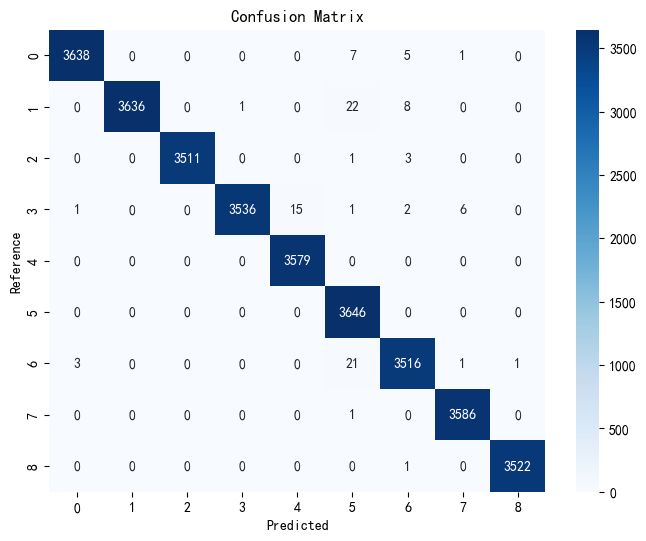

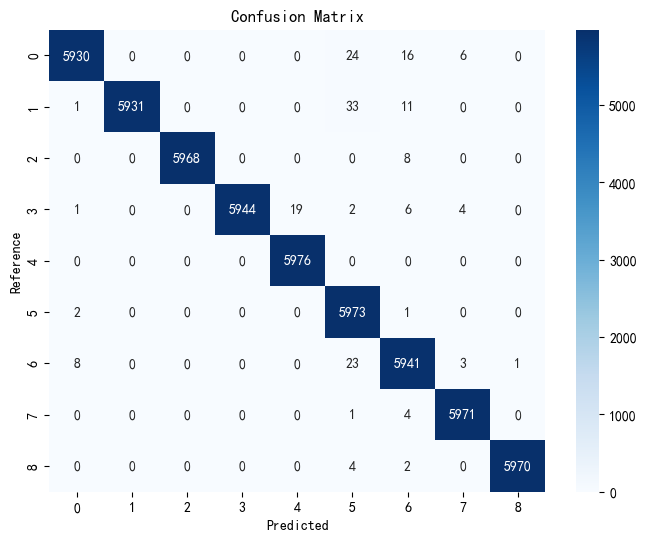

Fold 1 验证集Acc: 99.69% | 测试集Acc: 99.67%

====== Fold 2/5 ======


Fold 2 Epoch 1/300: 100%|██████████| 2017/2017 [00:19<00:00, 105.86batch/s, accuracy=94.5, grad_norm=0.55, loss=0.161]  


Epoch 1 验证集准确率: 96.11%


Fold 2 Epoch 2/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.26batch/s, accuracy=98.9, grad_norm=0.496, loss=0.0383] 


Epoch 2 验证集准确率: 81.26%


Fold 2 Epoch 3/300: 100%|██████████| 2017/2017 [00:20<00:00, 99.16batch/s, accuracy=99.3, grad_norm=0.325, loss=0.0251]  


Epoch 3 验证集准确率: 98.79%


Fold 2 Epoch 4/300: 100%|██████████| 2017/2017 [00:19<00:00, 102.79batch/s, accuracy=99.5, grad_norm=0.657, loss=0.0199]  


Epoch 4 验证集准确率: 96.19%


Fold 2 Epoch 5/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.23batch/s, accuracy=99.6, grad_norm=0.192, loss=0.0169]  


Epoch 5 验证集准确率: 98.57%


Fold 2 Epoch 6/300: 100%|██████████| 2017/2017 [00:20<00:00, 100.39batch/s, accuracy=99.6, grad_norm=0.823, loss=0.0161]  


Epoch 6 验证集准确率: 99.28%


Fold 2 Epoch 7/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.74batch/s, accuracy=99.6, grad_norm=0.148, loss=0.0152]  


Epoch 7 验证集准确率: 97.83%


Fold 2 Epoch 8/300: 100%|██████████| 2017/2017 [00:20<00:00, 97.74batch/s, accuracy=99.7, grad_norm=0.166, loss=0.013]    


Epoch 8 验证集准确率: 99.71%


Fold 2 Epoch 9/300: 100%|██████████| 2017/2017 [00:20<00:00, 98.06batch/s, accuracy=99.7, grad_norm=0.128, loss=0.0132]   


Epoch 9 验证集准确率: 85.79%


Fold 2 Epoch 10/300: 100%|██████████| 2017/2017 [00:21<00:00, 94.48batch/s, accuracy=99.7, grad_norm=0.169, loss=0.013]   


Epoch 10 验证集准确率: 98.97%


Fold 2 Epoch 11/300: 100%|██████████| 2017/2017 [00:20<00:00, 96.56batch/s, accuracy=99.9, grad_norm=0.198, loss=0.00521]  


Epoch 11 验证集准确率: 99.46%


Fold 2 Epoch 12/300: 100%|██████████| 2017/2017 [00:20<00:00, 97.17batch/s, accuracy=99.9, grad_norm=1.07, loss=0.0072]   


Epoch 12 验证集准确率: 97.14%


Fold 2 Epoch 13/300: 100%|██████████| 2017/2017 [00:20<00:00, 98.71batch/s, accuracy=99.9, grad_norm=0.0996, loss=0.00617] 


Epoch 13 验证集准确率: 99.76%


Fold 2 Epoch 14/300: 100%|██████████| 2017/2017 [00:20<00:00, 96.53batch/s, accuracy=99.9, grad_norm=1.03, loss=0.00664]   


Epoch 14 验证集准确率: 96.85%


Fold 2 Epoch 15/300: 100%|██████████| 2017/2017 [00:21<00:00, 95.65batch/s, accuracy=99.9, grad_norm=0.114, loss=0.00697]  


Epoch 15 验证集准确率: 99.18%


Fold 2 Epoch 16/300: 100%|██████████| 2017/2017 [00:20<00:00, 98.20batch/s, accuracy=99.9, grad_norm=0.839, loss=0.00707]  


Epoch 16 验证集准确率: 99.96%


Fold 2 Epoch 17/300: 100%|██████████| 2017/2017 [00:20<00:00, 100.19batch/s, accuracy=99.9, grad_norm=0.355, loss=0.00653] 


Epoch 17 验证集准确率: 99.72%


Fold 2 Epoch 18/300: 100%|██████████| 2017/2017 [00:21<00:00, 95.80batch/s, accuracy=99.9, grad_norm=0.0371, loss=0.00714] 


Epoch 18 验证集准确率: 99.89%


Fold 2 Epoch 19/300: 100%|██████████| 2017/2017 [00:21<00:00, 94.14batch/s, accuracy=99.9, grad_norm=0.287, loss=0.00624] 


Epoch 19 验证集准确率: 98.58%


Fold 2 Epoch 20/300: 100%|██████████| 2017/2017 [00:21<00:00, 95.57batch/s, accuracy=99.9, grad_norm=0.133, loss=0.00638] 


Epoch 20 验证集准确率: 99.46%


Fold 2 Epoch 21/300: 100%|██████████| 2017/2017 [00:20<00:00, 97.15batch/s, accuracy=100, grad_norm=0.109, loss=0.00304]   


Epoch 21 验证集准确率: 99.98%


Fold 2 Epoch 22/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.63batch/s, accuracy=100, grad_norm=0.265, loss=0.00379] 


Epoch 22 验证集准确率: 99.88%


Fold 2 Epoch 23/300: 100%|██████████| 2017/2017 [00:19<00:00, 102.20batch/s, accuracy=100, grad_norm=0.257, loss=0.00386] 


Epoch 23 验证集准确率: 99.96%


Fold 2 Epoch 24/300: 100%|██████████| 2017/2017 [00:20<00:00, 100.68batch/s, accuracy=100, grad_norm=0.116, loss=0.00377]  


Epoch 24 验证集准确率: 99.96%


Fold 2 Epoch 25/300: 100%|██████████| 2017/2017 [00:19<00:00, 102.85batch/s, accuracy=100, grad_norm=0.0405, loss=0.00365]


Epoch 25 验证集准确率: 99.93%


Fold 2 Epoch 26/300: 100%|██████████| 2017/2017 [00:19<00:00, 105.03batch/s, accuracy=100, grad_norm=0.197, loss=0.00411]  


Epoch 26 验证集准确率: 99.97%


Fold 2 Epoch 27/300: 100%|██████████| 2017/2017 [00:18<00:00, 106.63batch/s, accuracy=100, grad_norm=0.144, loss=0.00416] 


Epoch 27 验证集准确率: 99.97%


Fold 2 Epoch 28/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.99batch/s, accuracy=100, grad_norm=0.216, loss=0.00394]  


Epoch 28 验证集准确率: 99.92%


Fold 2 Epoch 29/300: 100%|██████████| 2017/2017 [00:20<00:00, 97.48batch/s, accuracy=99.9, grad_norm=0.275, loss=0.00422]  


Epoch 29 验证集准确率: 99.91%
早停，连续 8 个 epoch 验证集准确率未提升。


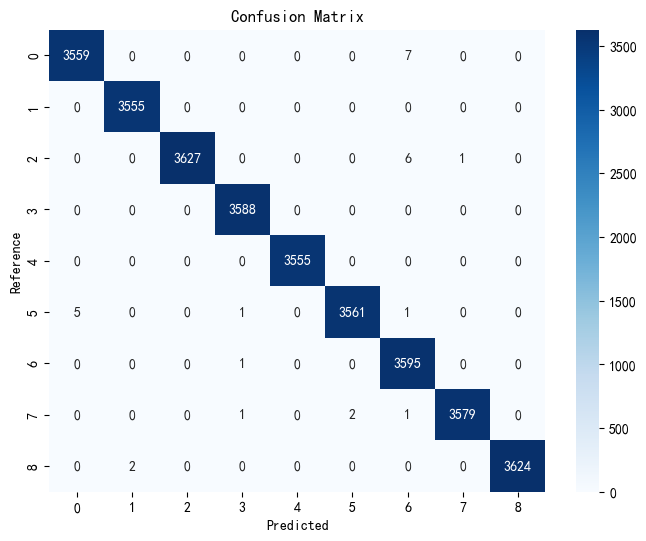

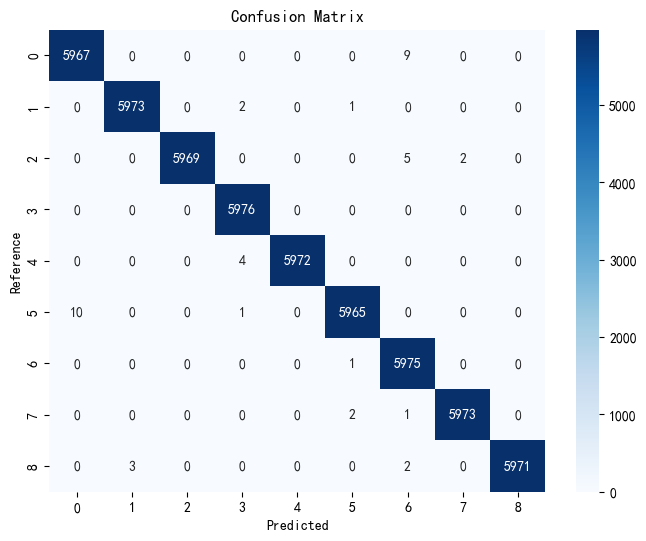

Fold 2 验证集Acc: 99.91% | 测试集Acc: 99.92%

====== Fold 3/5 ======


Fold 3 Epoch 1/300: 100%|██████████| 2017/2017 [00:19<00:00, 102.44batch/s, accuracy=94.9, grad_norm=1.14, loss=0.153]  


Epoch 1 验证集准确率: 97.86%


Fold 3 Epoch 2/300: 100%|██████████| 2017/2017 [00:19<00:00, 105.22batch/s, accuracy=98.9, grad_norm=0.489, loss=0.0385] 


Epoch 2 验证集准确率: 95.35%


Fold 3 Epoch 3/300: 100%|██████████| 2017/2017 [00:18<00:00, 110.20batch/s, accuracy=99.3, grad_norm=1.27, loss=0.0259]  


Epoch 3 验证集准确率: 95.04%


Fold 3 Epoch 4/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.64batch/s, accuracy=99.4, grad_norm=0.463, loss=0.0214]  


Epoch 4 验证集准确率: 97.80%


Fold 3 Epoch 5/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.20batch/s, accuracy=99.5, grad_norm=0.073, loss=0.0178]  


Epoch 5 验证集准确率: 99.84%


Fold 3 Epoch 6/300: 100%|██████████| 2017/2017 [00:18<00:00, 106.25batch/s, accuracy=99.6, grad_norm=0.0689, loss=0.0155]  


Epoch 6 验证集准确率: 98.97%


Fold 3 Epoch 7/300: 100%|██████████| 2017/2017 [00:18<00:00, 107.92batch/s, accuracy=99.6, grad_norm=0.516, loss=0.0146]  


Epoch 7 验证集准确率: 95.72%


Fold 3 Epoch 8/300: 100%|██████████| 2017/2017 [00:18<00:00, 109.69batch/s, accuracy=99.7, grad_norm=0.319, loss=0.0136]  


Epoch 8 验证集准确率: 98.74%


Fold 3 Epoch 9/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.80batch/s, accuracy=99.7, grad_norm=0.223, loss=0.0134]  


Epoch 9 验证集准确率: 99.84%


Fold 3 Epoch 10/300: 100%|██████████| 2017/2017 [00:18<00:00, 108.19batch/s, accuracy=99.7, grad_norm=1.5, loss=0.0115]    


Epoch 10 验证集准确率: 99.86%


Fold 3 Epoch 11/300: 100%|██████████| 2017/2017 [00:18<00:00, 111.67batch/s, accuracy=99.9, grad_norm=0.508, loss=0.00583]  


Epoch 11 验证集准确率: 99.31%


Fold 3 Epoch 12/300: 100%|██████████| 2017/2017 [00:18<00:00, 109.44batch/s, accuracy=99.9, grad_norm=0.39, loss=0.00695]  


Epoch 12 验证集准确率: 99.79%


Fold 3 Epoch 13/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.31batch/s, accuracy=99.9, grad_norm=2.11, loss=0.00691]  


Epoch 13 验证集准确率: 99.95%


Fold 3 Epoch 14/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.85batch/s, accuracy=99.9, grad_norm=0.606, loss=0.00726] 


Epoch 14 验证集准确率: 99.68%


Fold 3 Epoch 15/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.52batch/s, accuracy=99.9, grad_norm=0.703, loss=0.00637] 


Epoch 15 验证集准确率: 99.71%


Fold 3 Epoch 16/300: 100%|██████████| 2017/2017 [00:18<00:00, 107.24batch/s, accuracy=99.9, grad_norm=0.158, loss=0.00721] 


Epoch 16 验证集准确率: 99.89%


Fold 3 Epoch 17/300: 100%|██████████| 2017/2017 [00:18<00:00, 107.32batch/s, accuracy=99.9, grad_norm=0.226, loss=0.00724] 


Epoch 17 验证集准确率: 99.65%


Fold 3 Epoch 18/300: 100%|██████████| 2017/2017 [00:19<00:00, 106.07batch/s, accuracy=99.9, grad_norm=0.126, loss=0.00693] 


Epoch 18 验证集准确率: 98.10%


Fold 3 Epoch 19/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.10batch/s, accuracy=99.9, grad_norm=0.263, loss=0.00631] 


Epoch 19 验证集准确率: 97.38%


Fold 3 Epoch 20/300: 100%|██████████| 2017/2017 [00:20<00:00, 97.18batch/s, accuracy=99.9, grad_norm=0.39, loss=0.00651]   


Epoch 20 验证集准确率: 92.86%


Fold 3 Epoch 21/300: 100%|██████████| 2017/2017 [00:19<00:00, 102.71batch/s, accuracy=100, grad_norm=0.207, loss=0.00323]  


Epoch 21 验证集准确率: 99.97%


Fold 3 Epoch 22/300: 100%|██████████| 2017/2017 [00:20<00:00, 99.18batch/s, accuracy=100, grad_norm=0.258, loss=0.00369]  


Epoch 22 验证集准确率: 99.86%


Fold 3 Epoch 23/300: 100%|██████████| 2017/2017 [00:18<00:00, 107.58batch/s, accuracy=100, grad_norm=0.13, loss=0.00356]   


Epoch 23 验证集准确率: 99.98%


Fold 3 Epoch 24/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.53batch/s, accuracy=100, grad_norm=2.33, loss=0.0037]   


Epoch 24 验证集准确率: 99.89%


Fold 3 Epoch 25/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.61batch/s, accuracy=100, grad_norm=0.0463, loss=0.00409] 


Epoch 25 验证集准确率: 99.98%


Fold 3 Epoch 26/300: 100%|██████████| 2017/2017 [00:18<00:00, 107.59batch/s, accuracy=100, grad_norm=0.163, loss=0.00389] 


Epoch 26 验证集准确率: 99.93%


Fold 3 Epoch 27/300: 100%|██████████| 2017/2017 [00:20<00:00, 99.06batch/s, accuracy=100, grad_norm=0.0899, loss=0.00373] 


Epoch 27 验证集准确率: 99.83%


Fold 3 Epoch 28/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.54batch/s, accuracy=100, grad_norm=0.545, loss=0.0037]  


Epoch 28 验证集准确率: 99.94%


Fold 3 Epoch 29/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.27batch/s, accuracy=99.9, grad_norm=0.0884, loss=0.00434]


Epoch 29 验证集准确率: 99.91%
早停，连续 8 个 epoch 验证集准确率未提升。


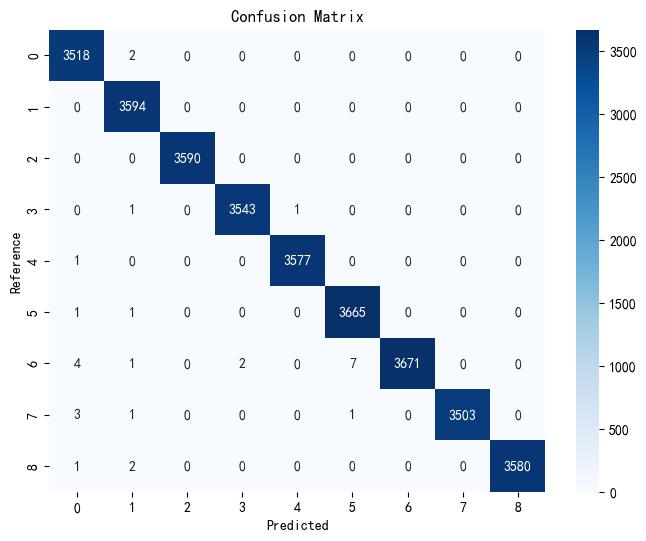

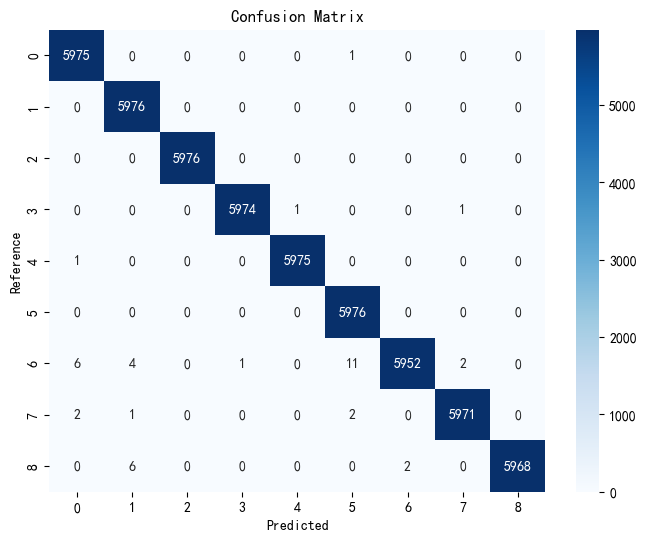

Fold 3 验证集Acc: 99.91% | 测试集Acc: 99.92%

====== Fold 4/5 ======


Fold 4 Epoch 1/300: 100%|██████████| 2017/2017 [00:18<00:00, 106.58batch/s, accuracy=94.4, grad_norm=1.76, loss=0.165]  


Epoch 1 验证集准确率: 98.27%


Fold 4 Epoch 2/300: 100%|██████████| 2017/2017 [00:18<00:00, 111.06batch/s, accuracy=99, grad_norm=0.529, loss=0.0369]   


Epoch 2 验证集准确率: 97.86%


Fold 4 Epoch 3/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.51batch/s, accuracy=99.3, grad_norm=0.636, loss=0.0252] 


Epoch 3 验证集准确率: 93.04%


Fold 4 Epoch 4/300: 100%|██████████| 2017/2017 [00:20<00:00, 98.42batch/s, accuracy=99.4, grad_norm=1.05, loss=0.0199]    


Epoch 4 验证集准确率: 98.70%


Fold 4 Epoch 5/300: 100%|██████████| 2017/2017 [00:18<00:00, 106.59batch/s, accuracy=99.6, grad_norm=0.256, loss=0.0172]  


Epoch 5 验证集准确率: 94.75%


Fold 4 Epoch 6/300: 100%|██████████| 2017/2017 [00:19<00:00, 102.82batch/s, accuracy=99.6, grad_norm=0.108, loss=0.0163]  


Epoch 6 验证集准确率: 99.46%


Fold 4 Epoch 7/300: 100%|██████████| 2017/2017 [00:20<00:00, 96.35batch/s, accuracy=99.7, grad_norm=0.894, loss=0.0136]   


Epoch 7 验证集准确率: 99.66%


Fold 4 Epoch 8/300: 100%|██████████| 2017/2017 [00:19<00:00, 102.43batch/s, accuracy=99.6, grad_norm=0.382, loss=0.0144]  


Epoch 8 验证集准确率: 94.14%


Fold 4 Epoch 9/300: 100%|██████████| 2017/2017 [00:20<00:00, 99.60batch/s, accuracy=99.7, grad_norm=0.627, loss=0.0131]   


Epoch 9 验证集准确率: 97.54%


Fold 4 Epoch 10/300: 100%|██████████| 2017/2017 [00:19<00:00, 105.63batch/s, accuracy=99.7, grad_norm=0.538, loss=0.0129]  


Epoch 10 验证集准确率: 90.72%


Fold 4 Epoch 11/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.07batch/s, accuracy=99.9, grad_norm=0.089, loss=0.00593]  


Epoch 11 验证集准确率: 99.98%


Fold 4 Epoch 12/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.96batch/s, accuracy=99.9, grad_norm=0.311, loss=0.00661] 


Epoch 12 验证集准确率: 99.85%


Fold 4 Epoch 13/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.70batch/s, accuracy=99.9, grad_norm=0.171, loss=0.00663] 


Epoch 13 验证集准确率: 99.70%


Fold 4 Epoch 14/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.18batch/s, accuracy=99.9, grad_norm=0.1, loss=0.00682]   


Epoch 14 验证集准确率: 99.55%


Fold 4 Epoch 15/300: 100%|██████████| 2017/2017 [00:19<00:00, 105.61batch/s, accuracy=99.9, grad_norm=0.839, loss=0.00627] 


Epoch 15 验证集准确率: 98.91%


Fold 4 Epoch 16/300: 100%|██████████| 2017/2017 [00:18<00:00, 107.86batch/s, accuracy=99.9, grad_norm=0.0784, loss=0.00686]


Epoch 16 验证集准确率: 99.39%


Fold 4 Epoch 17/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.33batch/s, accuracy=99.9, grad_norm=2.15, loss=0.00697]  


Epoch 17 验证集准确率: 97.41%


Fold 4 Epoch 18/300: 100%|██████████| 2017/2017 [00:18<00:00, 107.64batch/s, accuracy=99.9, grad_norm=0.276, loss=0.00678] 


Epoch 18 验证集准确率: 99.69%


Fold 4 Epoch 19/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.52batch/s, accuracy=99.9, grad_norm=0.279, loss=0.00636] 


Epoch 19 验证集准确率: 99.04%
早停，连续 8 个 epoch 验证集准确率未提升。


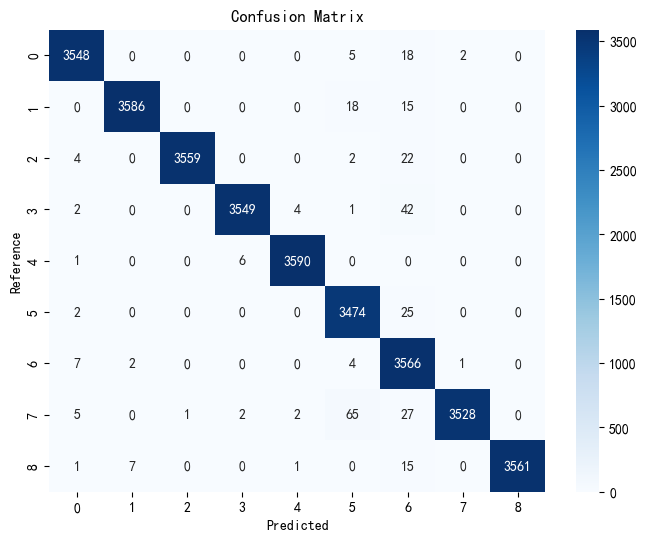

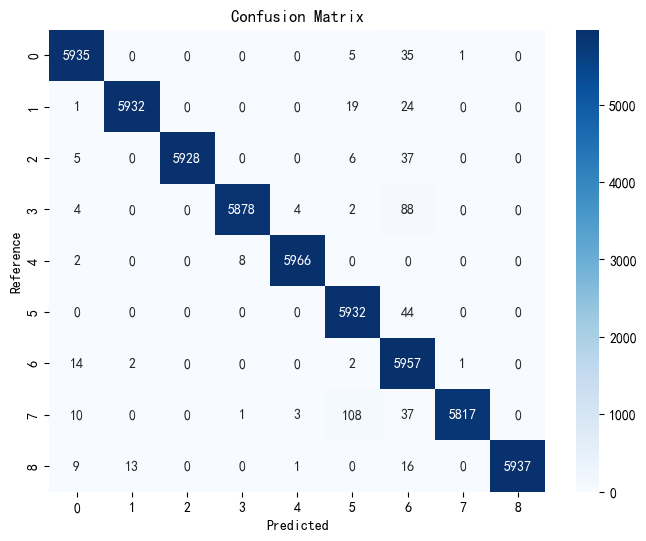

Fold 4 验证集Acc: 99.04% | 测试集Acc: 99.07%

====== Fold 5/5 ======


Fold 5 Epoch 1/300: 100%|██████████| 2017/2017 [00:18<00:00, 107.75batch/s, accuracy=94.7, grad_norm=0.407, loss=0.16]  


Epoch 1 验证集准确率: 98.29%


Fold 5 Epoch 2/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.36batch/s, accuracy=98.9, grad_norm=1.21, loss=0.0375]  


Epoch 2 验证集准确率: 97.38%


Fold 5 Epoch 3/300: 100%|██████████| 2017/2017 [00:20<00:00, 99.39batch/s, accuracy=99.3, grad_norm=0.38, loss=0.0257]   


Epoch 3 验证集准确率: 97.02%


Fold 5 Epoch 4/300: 100%|██████████| 2017/2017 [00:20<00:00, 100.80batch/s, accuracy=99.5, grad_norm=0.532, loss=0.0204] 


Epoch 4 验证集准确率: 98.54%


Fold 5 Epoch 5/300: 100%|██████████| 2017/2017 [00:20<00:00, 100.59batch/s, accuracy=99.5, grad_norm=0.277, loss=0.0181]  


Epoch 5 验证集准确率: 95.22%


Fold 5 Epoch 6/300: 100%|██████████| 2017/2017 [00:20<00:00, 99.96batch/s, accuracy=99.6, grad_norm=0.21, loss=0.0154]    


Epoch 6 验证集准确率: 98.87%


Fold 5 Epoch 7/300: 100%|██████████| 2017/2017 [00:18<00:00, 109.28batch/s, accuracy=99.7, grad_norm=0.379, loss=0.0144]  


Epoch 7 验证集准确率: 94.94%


Fold 5 Epoch 8/300: 100%|██████████| 2017/2017 [00:18<00:00, 109.40batch/s, accuracy=99.7, grad_norm=0.019, loss=0.0144]  


Epoch 8 验证集准确率: 95.48%


Fold 5 Epoch 9/300: 100%|██████████| 2017/2017 [00:19<00:00, 105.11batch/s, accuracy=99.7, grad_norm=0.36, loss=0.0143]   


Epoch 9 验证集准确率: 97.66%


Fold 5 Epoch 10/300: 100%|██████████| 2017/2017 [00:19<00:00, 103.71batch/s, accuracy=99.7, grad_norm=2.01, loss=0.0134]   


Epoch 10 验证集准确率: 90.72%


Fold 5 Epoch 11/300: 100%|██████████| 2017/2017 [00:18<00:00, 110.10batch/s, accuracy=99.9, grad_norm=0.216, loss=0.00577]  


Epoch 11 验证集准确率: 99.79%


Fold 5 Epoch 12/300: 100%|██████████| 2017/2017 [00:18<00:00, 107.05batch/s, accuracy=99.9, grad_norm=0.0288, loss=0.00691] 


Epoch 12 验证集准确率: 99.93%


Fold 5 Epoch 13/300: 100%|██████████| 2017/2017 [00:18<00:00, 109.24batch/s, accuracy=99.9, grad_norm=0.489, loss=0.00656] 


Epoch 13 验证集准确率: 99.87%


Fold 5 Epoch 14/300: 100%|██████████| 2017/2017 [00:19<00:00, 101.20batch/s, accuracy=99.9, grad_norm=0.149, loss=0.00727] 


Epoch 14 验证集准确率: 97.86%


Fold 5 Epoch 15/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.31batch/s, accuracy=99.9, grad_norm=0.182, loss=0.00681] 


Epoch 15 验证集准确率: 99.93%


Fold 5 Epoch 16/300: 100%|██████████| 2017/2017 [00:18<00:00, 109.29batch/s, accuracy=99.9, grad_norm=0.0719, loss=0.00753]


Epoch 16 验证集准确率: 99.80%


Fold 5 Epoch 17/300: 100%|██████████| 2017/2017 [00:18<00:00, 106.49batch/s, accuracy=99.9, grad_norm=1.73, loss=0.00635]  


Epoch 17 验证集准确率: 99.89%


Fold 5 Epoch 18/300: 100%|██████████| 2017/2017 [00:19<00:00, 104.48batch/s, accuracy=99.9, grad_norm=1.34, loss=0.00768]  


Epoch 18 验证集准确率: 99.94%


Fold 5 Epoch 19/300: 100%|██████████| 2017/2017 [00:20<00:00, 97.07batch/s, accuracy=99.9, grad_norm=3.28, loss=0.00684]   


Epoch 19 验证集准确率: 99.72%


Fold 5 Epoch 20/300: 100%|██████████| 2017/2017 [00:19<00:00, 105.63batch/s, accuracy=99.9, grad_norm=0.071, loss=0.00604] 


Epoch 20 验证集准确率: 95.51%
早停，连续 8 个 epoch 验证集准确率未提升。


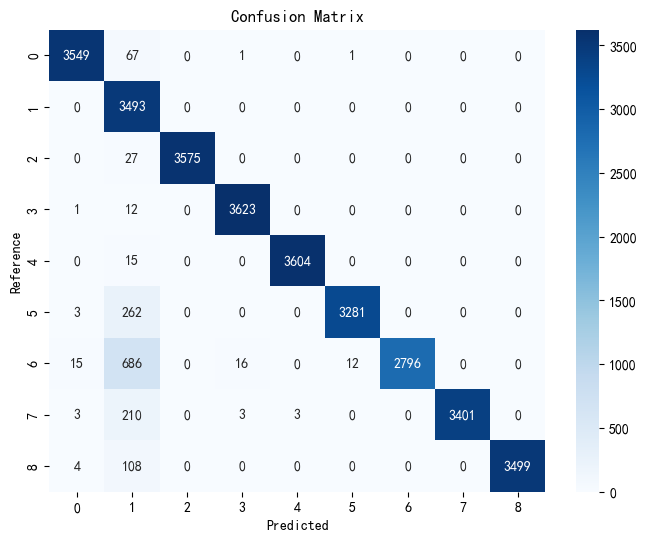

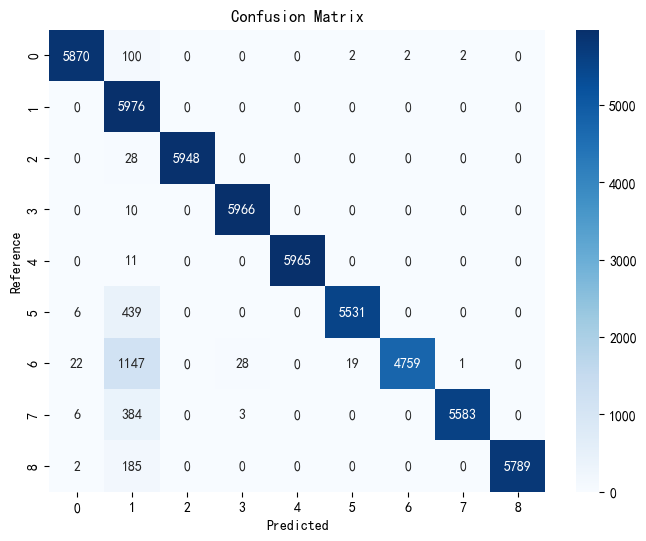

Fold 5 验证集Acc: 95.51% | 测试集Acc: 95.54%
最佳验证集Acc=99.93%, 测试集Acc=95.54%

====== 所有折训练完成 ======
平均验证集准确率: 98.81% ± 1.68%
独立测试集平均准确率: 98.82% ± 1.67%


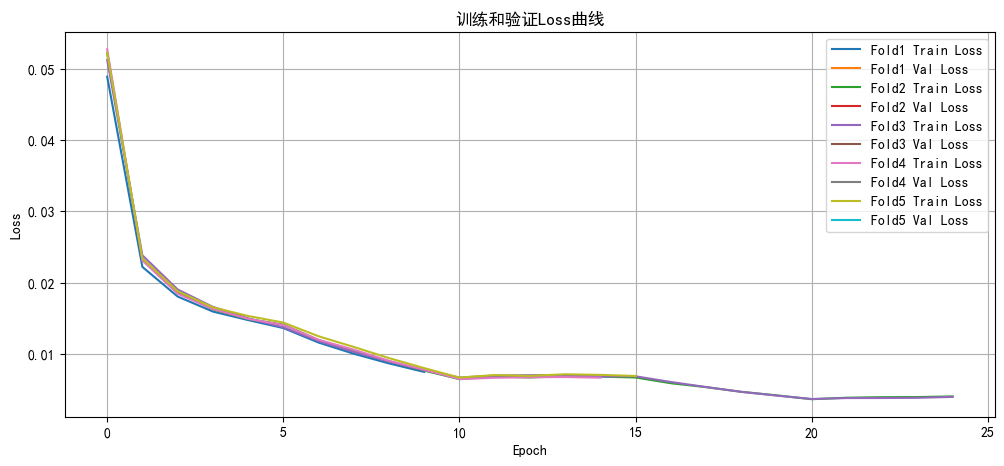

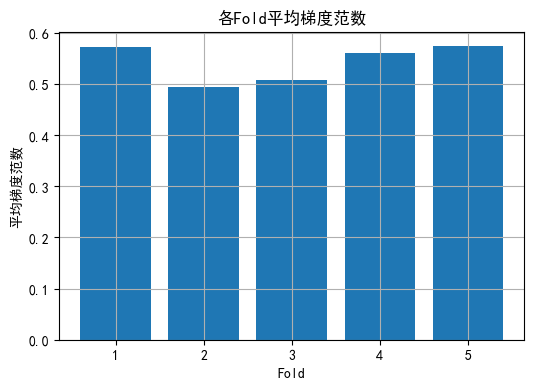

In [ ]:
# ResNet
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import scipy.io as sio
from  data_utilities import *
import h5py  # 用于v7.3格式.mat文件读取
import sys
from sklearn.model_selection import train_test_split


# ================= 参数设置 =================
# 数据路径和文件
data_path = "E:/rf_datasets/"  # 存放所有.mat文件的文件夹路径

# 信号参数
SNR_dB = False           # 信噪比，AWGN时使用
fs = 5e6              # 采样率 Hz
fc = 5.9e9            # 载波频率 Hz
v = False               # 目标速度 km/h（多普勒计算）

# 数据预处理开关
apply_doppler = False    
apply_awgn = False

# 模型超参数
raw_input_dim = 2       # 输入维度(I/Q)
model_dim = 64         # Transformer特征维度
num_heads = 8           # 注意力头数
num_layers = 2          # Transformer层数
dropout = 0.1           # dropout概率

# 训练参数
batch_size = 64
num_epochs = 300
learning_rate = 1e-3
patience = 8            # 早停耐心
n_splits = 5            # K折交叉验证折数
weight_decay = 5e-4

# ================= 多普勒和AWGN处理函数 =================
def compute_doppler_shift(v, fc):
    c = 3e8
    v = v/3.6 # 转换为m/s
    return (v / c) * fc

def apply_doppler_shift(signal, fd, fs):
    t = np.arange(signal.shape[-1]) / fs
    doppler_phase = np.exp(1j * 2 * np.pi * fd * t)
    return signal * doppler_phase

def add_awgn(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / (10**(snr_db/10))
    
    # 关键修改：分别生成独立的高斯随机数
    noise_real = np.random.randn(*signal.shape)
    noise_imag = np.random.randn(*signal.shape)
    noise = np.sqrt(noise_power/2) * (noise_real + 1j*noise_imag)
    
    return signal + noise

# ================= 数据加载与预处理 =================
def load_and_preprocess_with_grouping(
    mat_folder,
    group_size=288,
    apply_doppler=False,
    target_velocity=30,
    apply_awgn=False,
    snr_db=20,
    fs=5e6,
    fc=5.9e9,
):
    # 读取所有mat文件
    mat_files = glob.glob(os.path.join(mat_folder, '*.mat'))
    print(f"共找到 {len(mat_files)} 个 .mat 文件")

    # 计算多普勒频移（如果需要）
    fd = compute_doppler_shift(target_velocity, fc)
    print(f"目标速度 {target_velocity} km/h，对应多普勒频移 {fd:.2f} Hz")

    # 存放每个文件的信号和对应标签
    X_files = []
    y_files = []
    label_set = set()

    # 读取文件数据
    for file in tqdm(mat_files, desc='读取数据'):
        with h5py.File(file, 'r') as f:
            rfDataset = f['rfDataset']
            dmrs_struct = rfDataset['dmrs'][:]
            dmrs_complex = dmrs_struct['real'] + 1j * dmrs_struct['imag']

            txID_uint16 = rfDataset['txID'][:].flatten()
            tx_id = ''.join(chr(c) for c in txID_uint16 if c != 0)

            processed_signals = []
            for i in range(dmrs_complex.shape[0]):
                sig = dmrs_complex[i, :]
                if apply_doppler:
                    sig = apply_doppler_shift(sig, fd, fs)
                if apply_awgn:
                    sig = add_awgn(sig, snr_db)

                iq = np.stack((sig.real, sig.imag), axis=-1)  # (288, 2)
                processed_signals.append(iq)
            processed_signals = np.array(processed_signals)  # (num_samples, 288, 2)

            X_files.append(processed_signals)
            y_files.append(tx_id)
            label_set.add(tx_id)

    label_list = sorted(list(label_set))
    label_to_idx = {label: i for i, label in enumerate(label_list)}

    X_all_list = []
    y_all_list = []

    for label in label_list:
        # 找出该类别对应的所有文件索引
        files_idx = [i for i, y in enumerate(y_files) if y == label]
        num_files = len(files_idx)
        if num_files == 0:
            continue

        samples_per_file = group_size // num_files  # 每文件取多少条样本
        if samples_per_file == 0:
            print(f"[WARN] 类别 {label} 文件数量过多，导致每文件样本数为0，跳过该类别")
            continue

        # 计算该类别能组成多少个完整的group（每group取每文件samples_per_file条数据）
        min_samples = min([X_files[i].shape[0] for i in files_idx])
        max_groups = min_samples // samples_per_file
        if max_groups == 0:
            print(f"[WARN] 类别 {label} 样本不足，跳过")
            continue

        # 按组循环
        for group_i in range(max_groups):
            # 取每个文件连续samples_per_file条数据
            pieces = []
            for fi in files_idx:
                start = group_i * samples_per_file
                end = start + samples_per_file
                piece = X_files[fi][start:end]  # (samples_per_file, 288, 2)
                pieces.append(piece)

            # 拼接成 (num_files * samples_per_file, 288, 2) == (288, 288, 2)
            big_block = np.concatenate(pieces, axis=0)

            # 转置采样点和样本条数维度：(288, 288, 2) -> (288, 288, 2)
            big_block_t = np.transpose(big_block, (1, 0, 2))

            # big_block_t是288条样本，每条样本长度288
            X_all_list.append(big_block_t)  # (288, 288, 2)
            y_all_list.append(np.full(group_size, label_to_idx[label], dtype=np.int64))

    # 合并所有类别数据
    X_all = np.concatenate(X_all_list, axis=0)  # (总样本数, 288, 2)
    y_all = np.concatenate(y_all_list, axis=0)  # (总样本数, )

    print(f"[INFO] 处理后样本数: {X_all.shape[0]}, 每样本长度: {X_all.shape[1]}")

    return X_all, y_all, label_to_idx

def split_by_rx_id(X_all, y_all, rx_id_all, test_rx_id_str):
    test_mask = (rx_id_all == test_rx_id_str)
    trainval_mask = ~test_mask

    X_trainval = X_all[trainval_mask]
    y_trainval = y_all[trainval_mask]

    X_test = X_all[test_mask]
    y_test = y_all[test_mask]

    print(f"[INFO] 按接收机划分测试集 rxID={test_rx_id_str}")
    print(f"训练+验证集样本数: {X_trainval.shape[0]}, 测试集样本数: {X_test.shape[0]}")

    return X_trainval, y_trainval, X_test, y_test


# ================= 模型定义 =================
# ===================== 1D ResNet18 =====================
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock1D(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class ResNet18_1D(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_1D, self).__init__()

        self.in_planes = 64

        # 输入: (B, 2, 288)
        self.conv1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)   # → (B,64,144)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # →72

        # ResNet18 标准结构
        self.layer1 = self._make_layer(64, 2, stride=1)   # 72
        self.layer2 = self._make_layer(128, 2, stride=2)  # 36
        self.layer3 = self._make_layer(256, 2, stride=2)  # 18
        self.layer4 = self._make_layer(512, 2, stride=2)  # 9

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride):
        downsample = None

        # 如果通道数或步幅改变，需要下采样匹配维度
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes),
            )

        layers = []
        layers.append(BasicBlock1D(self.in_planes, planes,
                                   stride=stride,
                                   downsample=downsample))
        self.in_planes = planes

        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # x: (B, 288, 2) → 转成 (B, 2, 288)
        x = x.permute(0, 2, 1)

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)   # (B,512,1)
        x = x.squeeze(-1)     # (B,512)
        x = self.fc(x)
        return x

# ================= 训练辅助 =================
def compute_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

def moving_average(x, w=5):
    x = np.array(x)
    if len(x) == 0:
        return np.array([])   # 空的直接返回空数组
    if w <= 0:
        w = 1                 # 避免 np.ones(0)
    if len(x) < w:
        w = len(x)            # 窗口不能比序列长
    return np.convolve(x, np.ones(w), 'valid') / w

# ================= 主训练流程 =================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] 使用设备: {device}")

    # 1. 加载数据
    X_all, y_all, label_to_idx = load_and_preprocess_with_grouping(
        data_path,
        group_size=288,
        apply_doppler=apply_doppler,
        target_velocity=v,
        apply_awgn=apply_awgn,
        snr_db=SNR_dB,
        fs=fs,
        fc=fc
    )

    # 2. 创建结果保存目录
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    script_name = "LTE-V_cross_fluently"
    folder_name = f"{timestamp}_{script_name}_SNR{SNR_dB}dB_fd{int(compute_doppler_shift(v, fc))}_classes_{len(label_to_idx)}_ResNet"
    save_folder = os.path.join(os.getcwd(), "training_results", folder_name)
    os.makedirs(save_folder, exist_ok=True)
    results_file = os.path.join(save_folder, "results.txt")

    # 记录超参数
    with open(results_file, "a") as f:
        f.write(f"\n模型超参数设置:\n")
        f.write(f"  batch_size: {batch_size}\n")
        f.write(f"  learning_rate: {learning_rate}\n")
        f.write(f"  weight_decay: {weight_decay}\n")
        f.write(f"  num_epochs: {num_epochs}\n")
        f.write(f"  model_dim: {model_dim}\n")
        f.write(f"  num_heads: {num_heads}\n")
        f.write(f"  num_layers: {num_layers}\n")
        f.write(f"  dropout: {dropout}\n")
        f.write(f"  patience: {patience}\n")

    # 3. 划分训练和测试集
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_all, y_all, test_size=0.25, stratify=y_all, random_state=42
    )

    # 4. 构造 TensorDataset 和 DataLoader
    full_dataset = TensorDataset(torch.tensor(X_trainval, dtype=torch.float32),
                                 torch.tensor(y_trainval, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    print(f"[INFO] 最终训练集: {X_trainval.shape}, 测试集: {X_test.shape}")

    # Step 2: KFold
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    indices = np.arange(len(full_dataset))

    fold_results = []
    val_results = []
    final_test_results = []
    avg_grad_norms_per_fold = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f"\n====== Fold {fold+1}/{n_splits} ======")

        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, drop_last=False)

        model = ResNet18_1D(num_classes=len(label_to_idx)).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        grad_norms = []

        best_val_acc = 0.0
        patience_counter = 0
        best_model_wts = None

        for epoch in range(num_epochs):
            model.train()
            running_train_loss, correct_train, total_train = 0.0, 0, 0
            batch_grad_norms = []

            with tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()

                    grad_norm = compute_grad_norm(model)
                    batch_grad_norms.append(grad_norm)

                    optimizer.step()

                    running_train_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()

                    tepoch.set_postfix(loss=running_train_loss / len(train_loader),
                                       accuracy=100 * correct_train / total_train,
                                       grad_norm=grad_norm)

            epoch_train_loss = running_train_loss / len(train_loader)
            train_losses.append(epoch_train_loss)
            train_accuracies.append(100 * correct_train / total_train)
            avg_grad_norm = np.mean(batch_grad_norms)
            grad_norms.append(avg_grad_norm)

           # 验证阶段
            model.eval()
            correct_val, total_val = 0, 0

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    _, val_predicted = torch.max(val_outputs, 1)
                    total_val += val_labels.size(0)
                    correct_val += (val_predicted == val_labels).sum().item()

            val_acc = 100 * correct_val / total_val
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch+1} 验证集准确率: {val_acc:.2f}%")

            # 早停判断（以 val_acc 为准，增加 min_delta 阈值）
            min_delta = 0.01  # 设定微小提升阈值
            if val_acc > best_val_acc + min_delta:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_wts = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"早停，连续 {patience} 个 epoch 验证集准确率未提升。")
                    break

            scheduler.step()


        # 保存训练曲线
        fold_results.append({
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_acc': val_accuracies,
            'train_acc': train_accuracies,
            'grad_norms': grad_norms
        })
        avg_grad_norms_per_fold.append(np.mean(grad_norms))

        # 恢复最佳权重
        model.load_state_dict(best_model_wts)

        # 验证集评估
        val_acc, val_cm = evaluate_model(model, val_loader, device, len(label_to_idx))
        val_results.append(val_acc)
        plot_confusion_matrix(val_cm, save_path=os.path.join(save_folder, f"confusion_matrix_val_fold{fold+1}.png"))

        # 测试集评估
        test_acc, test_cm = evaluate_model(model, test_loader, device, len(label_to_idx))
        final_test_results.append(test_acc)
        plot_confusion_matrix(test_cm, save_path=os.path.join(save_folder, f"confusion_matrix_test_fold{fold+1}.png"))

        print(f"Fold {fold+1} 验证集Acc: {val_acc:.2f}% | 测试集Acc: {test_acc:.2f}%")

        # 保存最佳模型权重
        torch.save(best_model_wts, os.path.join(save_folder, f"best_model_fold{fold+1}.pth"))

        # 保存结果及超参数
        with open(results_file, "a") as f:
            f.write(f"\n训练结束\n")
            f.write(f"最佳验证集Acc: {best_val_acc:.2f}%\n")
            f.write(f"测试集准确率: {test_acc:.2f}%\n")

    print(f"最佳验证集Acc={best_val_acc:.2f}%, 测试集Acc={test_acc:.2f}%")

    print("\n====== 所有折训练完成 ======")
    print(f"平均验证集准确率: {np.mean(val_results):.2f}% ± {np.std(val_results):.2f}%")
    print(f"独立测试集平均准确率: {np.mean(final_test_results):.2f}% ± {np.std(final_test_results):.2f}%")

    with open(results_file, "a") as f:
        f.write(f"\n所有折平均验证集准确率: {np.mean(val_results):.2f}% ± {np.std(val_results):.2f}%\n")
        f.write(f"所有折平均测试集准确率: {np.mean(final_test_results):.2f}% ± {np.std(final_test_results):.2f}%\n")

    # 绘制训练曲线和梯度范数
    plot_training_curves(fold_results, save_folder)
    plot_grad_norms(avg_grad_norms_per_fold, save_folder)



def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return acc, cm

def plot_training_curves(fold_results, save_folder):
    plt.figure(figsize=(12,5))
    for i, res in enumerate(fold_results):
        plt.plot(moving_average(res['train_loss']), label=f'Fold{i+1} Train Loss')
        plt.plot(moving_average(res['val_loss']), label=f'Fold{i+1} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('训练和验证Loss曲线')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(save_folder, 'loss_curves.png'))
    plt.show()

def plot_grad_norms(avg_grad_norms, save_folder):
    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(avg_grad_norms)+1), avg_grad_norms)
    plt.xlabel('Fold')
    plt.ylabel('平均梯度范数')
    plt.title('各Fold平均梯度范数')
    plt.grid()
    plt.savefig(os.path.join(save_folder, 'avg_grad_norms.png'))
    plt.show()

def plot_confusion_matrix(cm, save_path=None):
    plt.figure(figsize=(8,6))
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Reference')
    plt.xlabel('Predicted')

    if save_path:
        plt.savefig(save_path)
    plt.show()



if __name__ == "__main__":
    main()




================== 当前实验 SNR=20 dB ==================

[INFO] 使用设备: cuda
共找到 72 个 .mat 文件
目标速度 120 km/h，多普勒频移 655.56 Hz


读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.38it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.1325, Train Acc=95.65%, Val Loss=0.0487, Val Acc=98.53%, Grad Norm=1.0445
Fold 1, Epoch 2: Train Loss=0.0305, Train Acc=99.17%, Val Loss=0.1108, Val Acc=96.44%, Grad Norm=0.5474
Fold 1, Epoch 3: Train Loss=0.0203, Train Acc=99.45%, Val Loss=0.0251, Val Acc=99.40%, Grad Norm=0.4967
Fold 1, Epoch 4: Train Loss=0.0168, Train Acc=99.58%, Val Loss=0.0168, Val Acc=99.58%, Grad Norm=0.5079
Fold 1, Epoch 5: Train Loss=0.0149, Train Acc=99.64%, Val Loss=0.0130, Val Acc=99.70%, Grad Norm=0.5054
Fold 1, Epoch 6: Train Loss=0.0132, Train Acc=99.69%, Val Loss=0.6922, Val Acc=78.40%, Grad Norm=0.4998
Fold 1, Epoch 7: Train Loss=0.0129, Train Acc=99.69%, Val Loss=0.0464, Val Acc=98.68%, Grad Norm=0.5371
Fold 1, Epoch 8: Train Loss=0.0114, Train Acc=99.74%, Val Loss=0.0135, Val Acc=99.63%, Grad Norm=0.5047
Fold 1, Epoch 9: Train Loss=0.0107, Train Acc=99.76%, Val Loss=0.0736, Val Acc=97.91%, Grad Norm=0.5061
Fold 1, E

读取数据: 100%|██████████| 72/72 [00:09<00:00,  7.96it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.1138, Train Acc=96.25%, Val Loss=0.0595, Val Acc=98.28%, Grad Norm=1.0147
Fold 1, Epoch 2: Train Loss=0.0245, Train Acc=99.37%, Val Loss=0.3305, Val Acc=88.70%, Grad Norm=0.4667
Fold 1, Epoch 3: Train Loss=0.0169, Train Acc=99.57%, Val Loss=0.0091, Val Acc=99.79%, Grad Norm=0.4348
Fold 1, Epoch 4: Train Loss=0.0136, Train Acc=99.66%, Val Loss=0.0400, Val Acc=98.82%, Grad Norm=0.4341
Fold 1, Epoch 5: Train Loss=0.0113, Train Acc=99.72%, Val Loss=0.2552, Val Acc=90.75%, Grad Norm=0.4232
Fold 1, Epoch 6: Train Loss=0.0105, Train Acc=99.76%, Val Loss=0.0209, Val Acc=99.53%, Grad Norm=0.4188
Fold 1, Epoch 7: Train Loss=0.0095, Train Acc=99.80%, Val Loss=0.0052, Val Acc=99.90%, Grad Norm=0.4328
Fold 1, Epoch 8: Train Loss=0.0102, Train Acc=99.76%, Val Loss=0.0442, Val Acc=98.64%, Grad Norm=0.4733
Fold 1, Epoch 9: Train Loss=0.0094, Train Acc=99.79%, Val Loss=0.0033, Val Acc=99.93%, Grad Norm=0.4590
Fold 1, E

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.18it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.1064, Train Acc=96.53%, Val Loss=0.0364, Val Acc=98.98%, Grad Norm=0.9068
Fold 1, Epoch 2: Train Loss=0.0185, Train Acc=99.57%, Val Loss=0.0173, Val Acc=99.54%, Grad Norm=0.3810
Fold 1, Epoch 3: Train Loss=0.0128, Train Acc=99.69%, Val Loss=0.0143, Val Acc=99.73%, Grad Norm=0.3498
Fold 1, Epoch 4: Train Loss=0.0098, Train Acc=99.80%, Val Loss=0.1989, Val Acc=93.45%, Grad Norm=0.3255
Fold 1, Epoch 5: Train Loss=0.0093, Train Acc=99.80%, Val Loss=0.0128, Val Acc=99.77%, Grad Norm=0.3569
Fold 1, Epoch 6: Train Loss=0.0079, Train Acc=99.84%, Val Loss=0.0046, Val Acc=99.93%, Grad Norm=0.3351
Fold 1, Epoch 7: Train Loss=0.0064, Train Acc=99.87%, Val Loss=0.0047, Val Acc=99.91%, Grad Norm=0.2862
Fold 1, Epoch 8: Train Loss=0.0076, Train Acc=99.86%, Val Loss=0.0075, Val Acc=99.85%, Grad Norm=0.3551
Fold 1, Epoch 9: Train Loss=0.0071, Train Acc=99.86%, Val Loss=0.0035, Val Acc=99.92%, Grad Norm=0.3539
Fold 1, E

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.03it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0735, Train Acc=97.69%, Val Loss=0.0853, Val Acc=97.43%, Grad Norm=0.7168
Fold 1, Epoch 2: Train Loss=0.0140, Train Acc=99.69%, Val Loss=0.0271, Val Acc=99.14%, Grad Norm=0.3169
Fold 1, Epoch 3: Train Loss=0.0091, Train Acc=99.81%, Val Loss=0.0022, Val Acc=99.98%, Grad Norm=0.2823
Fold 1, Epoch 4: Train Loss=0.0073, Train Acc=99.86%, Val Loss=0.0022, Val Acc=99.97%, Grad Norm=0.2569
Fold 1, Epoch 5: Train Loss=0.0054, Train Acc=99.90%, Val Loss=0.0022, Val Acc=99.98%, Grad Norm=0.2270
Fold 1, Epoch 6: Train Loss=0.0059, Train Acc=99.88%, Val Loss=0.0009, Val Acc=99.99%, Grad Norm=0.2600
Fold 1, Epoch 7: Train Loss=0.0051, Train Acc=99.91%, Val Loss=0.0035, Val Acc=99.94%, Grad Norm=0.2467
Fold 1, Epoch 8: Train Loss=0.0064, Train Acc=99.88%, Val Loss=0.0013, Val Acc=99.98%, Grad Norm=0.3290
Fold 1, Epoch 9: Train Loss=0.0047, Train Acc=99.92%, Val Loss=0.0081, Val Acc=99.87%, Grad Norm=0.2504
Fold 1, E

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.42it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0623, Train Acc=98.06%, Val Loss=0.0255, Val Acc=99.47%, Grad Norm=0.6438
Fold 1, Epoch 2: Train Loss=0.0109, Train Acc=99.78%, Val Loss=0.1322, Val Acc=95.27%, Grad Norm=0.2515
Fold 1, Epoch 3: Train Loss=0.0073, Train Acc=99.86%, Val Loss=0.0008, Val Acc=100.00%, Grad Norm=0.2224
Fold 1, Epoch 4: Train Loss=0.0051, Train Acc=99.91%, Val Loss=0.0164, Val Acc=99.56%, Grad Norm=0.1530
Fold 1, Epoch 5: Train Loss=0.0055, Train Acc=99.89%, Val Loss=0.0041, Val Acc=99.97%, Grad Norm=0.2247
Fold 1, Epoch 6: Train Loss=0.0040, Train Acc=99.95%, Val Loss=0.0014, Val Acc=99.99%, Grad Norm=0.1844
Fold 1, Epoch 7: Train Loss=0.0040, Train Acc=99.94%, Val Loss=0.0009, Val Acc=99.99%, Grad Norm=0.2035
Fold 1, Epoch 8: Train Loss=0.0044, Train Acc=99.93%, Val Loss=0.0031, Val Acc=99.98%, Grad Norm=0.2312
Fold 1, Epoch 9: Train Loss=0.0037, Train Acc=99.96%, Val Loss=0.0013, Val Acc=99.99%, Grad Norm=0.1951
Fold 1, 

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.39it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0489, Train Acc=98.50%, Val Loss=0.0079, Val Acc=99.96%, Grad Norm=0.5951
Fold 1, Epoch 2: Train Loss=0.0107, Train Acc=99.77%, Val Loss=0.0015, Val Acc=99.98%, Grad Norm=0.2426
Fold 1, Epoch 3: Train Loss=0.0052, Train Acc=99.91%, Val Loss=0.0036, Val Acc=99.98%, Grad Norm=0.1518
Fold 1, Epoch 4: Train Loss=0.0047, Train Acc=99.93%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.1594
Fold 1, Epoch 5: Train Loss=0.0048, Train Acc=99.92%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.1727
Fold 1, Epoch 6: Train Loss=0.0038, Train Acc=99.95%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.1652
Fold 1, Epoch 7: Train Loss=0.0033, Train Acc=99.96%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.1493
Fold 1, Epoch 8: Train Loss=0.0042, Train Acc=99.93%, Val Loss=0.0009, Val Acc=99.99%, Grad Norm=0.2149
Fold 1, Epoch 9: Train Loss=0.0032, Train Acc=99.96%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1583
Fold

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.33it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0442, Train Acc=98.68%, Val Loss=0.0017, Val Acc=100.00%, Grad Norm=0.5130
Fold 1, Epoch 2: Train Loss=0.0085, Train Acc=99.84%, Val Loss=0.0013, Val Acc=100.00%, Grad Norm=0.1897
Fold 1, Epoch 3: Train Loss=0.0063, Train Acc=99.89%, Val Loss=0.0021, Val Acc=99.99%, Grad Norm=0.1788
Fold 1, Epoch 4: Train Loss=0.0049, Train Acc=99.91%, Val Loss=0.0007, Val Acc=100.00%, Grad Norm=0.1742
Fold 1, Epoch 5: Train Loss=0.0033, Train Acc=99.96%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1208
Fold 1, Epoch 6: Train Loss=0.0041, Train Acc=99.93%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1622
Fold 1, Epoch 7: Train Loss=0.0036, Train Acc=99.95%, Val Loss=0.0010, Val Acc=100.00%, Grad Norm=0.1617
Fold 1, Epoch 8: Train Loss=0.0034, Train Acc=99.95%, Val Loss=0.0004, Val Acc=100.00%, Grad Norm=0.1573
Fold 1, Epoch 9: Train Loss=0.0028, Train Acc=99.97%, Val Loss=0.0031, Val Acc=99.98%, Grad Norm=0.1344
早停

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.34it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0430, Train Acc=98.73%, Val Loss=0.0496, Val Acc=98.68%, Grad Norm=0.5174
Fold 1, Epoch 2: Train Loss=0.0091, Train Acc=99.83%, Val Loss=0.0020, Val Acc=99.99%, Grad Norm=0.1998
Fold 1, Epoch 3: Train Loss=0.0055, Train Acc=99.91%, Val Loss=0.0024, Val Acc=99.96%, Grad Norm=0.1584
Fold 1, Epoch 4: Train Loss=0.0053, Train Acc=99.90%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1782
Fold 1, Epoch 5: Train Loss=0.0031, Train Acc=99.96%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.1147
Fold 1, Epoch 6: Train Loss=0.0038, Train Acc=99.94%, Val Loss=0.0020, Val Acc=99.99%, Grad Norm=0.1604
Fold 1, Epoch 7: Train Loss=0.0037, Train Acc=99.95%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1375
Fold 1, Epoch 8: Train Loss=0.0033, Train Acc=99.95%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1543
Fold 1, Epoch 9: Train Loss=0.0035, Train Acc=99.95%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1674
Fold

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.34it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0464, Train Acc=98.58%, Val Loss=0.0781, Val Acc=98.17%, Grad Norm=0.5346
Fold 1, Epoch 2: Train Loss=0.0083, Train Acc=99.83%, Val Loss=0.0007, Val Acc=100.00%, Grad Norm=0.1961
Fold 1, Epoch 3: Train Loss=0.0055, Train Acc=99.90%, Val Loss=0.0017, Val Acc=99.98%, Grad Norm=0.1680
Fold 1, Epoch 4: Train Loss=0.0034, Train Acc=99.95%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.1199
Fold 1, Epoch 5: Train Loss=0.0043, Train Acc=99.93%, Val Loss=0.0028, Val Acc=100.00%, Grad Norm=0.1885
Fold 1, Epoch 6: Train Loss=0.0038, Train Acc=99.94%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1587
Fold 1, Epoch 7: Train Loss=0.0035, Train Acc=99.95%, Val Loss=0.0007, Val Acc=100.00%, Grad Norm=0.1475
Fold 1, Epoch 8: Train Loss=0.0033, Train Acc=99.96%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1612
Fold 1, Epoch 9: Train Loss=0.0027, Train Acc=99.97%, Val Loss=0.0004, Val Acc=100.00%, Grad Norm=0.1199
Fo

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.41it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0457, Train Acc=98.60%, Val Loss=0.0061, Val Acc=99.96%, Grad Norm=0.5271
Fold 1, Epoch 2: Train Loss=0.0082, Train Acc=99.85%, Val Loss=0.0073, Val Acc=99.91%, Grad Norm=0.1941
Fold 1, Epoch 3: Train Loss=0.0050, Train Acc=99.92%, Val Loss=0.0010, Val Acc=100.00%, Grad Norm=0.1483
Fold 1, Epoch 4: Train Loss=0.0050, Train Acc=99.91%, Val Loss=0.0519, Val Acc=98.64%, Grad Norm=0.1714
Fold 1, Epoch 5: Train Loss=0.0042, Train Acc=99.93%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.1561
Fold 1, Epoch 6: Train Loss=0.0036, Train Acc=99.96%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1574
Fold 1, Epoch 7: Train Loss=0.0035, Train Acc=99.95%, Val Loss=0.0041, Val Acc=99.94%, Grad Norm=0.1536
Fold 1, Epoch 8: Train Loss=0.0033, Train Acc=99.96%, Val Loss=0.0224, Val Acc=99.37%, Grad Norm=0.1402
Fold 1, Epoch 9: Train Loss=0.0031, Train Acc=99.96%, Val Loss=0.0009, Val Acc=100.00%, Grad Norm=0.1561
Fold 

读取数据: 100%|██████████| 72/72 [00:09<00:00,  7.99it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0419, Train Acc=98.75%, Val Loss=0.0398, Val Acc=99.16%, Grad Norm=0.5025
Fold 1, Epoch 2: Train Loss=0.0084, Train Acc=99.85%, Val Loss=0.0360, Val Acc=99.26%, Grad Norm=0.1833
Fold 1, Epoch 3: Train Loss=0.0060, Train Acc=99.89%, Val Loss=0.0007, Val Acc=100.00%, Grad Norm=0.1633
Fold 1, Epoch 4: Train Loss=0.0049, Train Acc=99.92%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1645
Fold 1, Epoch 5: Train Loss=0.0040, Train Acc=99.93%, Val Loss=0.0007, Val Acc=100.00%, Grad Norm=0.1613
Fold 1, Epoch 6: Train Loss=0.0031, Train Acc=99.96%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1184
Fold 1, Epoch 7: Train Loss=0.0034, Train Acc=99.96%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1338
Fold 1, Epoch 8: Train Loss=0.0035, Train Acc=99.95%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1578
Fold 1, Epoch 9: Train Loss=0.0029, Train Acc=99.97%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1439
Fo

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.32it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0422, Train Acc=98.73%, Val Loss=0.0962, Val Acc=96.64%, Grad Norm=0.5179
Fold 1, Epoch 2: Train Loss=0.0085, Train Acc=99.86%, Val Loss=0.0060, Val Acc=99.88%, Grad Norm=0.2029
Fold 1, Epoch 3: Train Loss=0.0053, Train Acc=99.90%, Val Loss=0.0121, Val Acc=99.74%, Grad Norm=0.1754
Fold 1, Epoch 4: Train Loss=0.0035, Train Acc=99.95%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.1126
Fold 1, Epoch 5: Train Loss=0.0048, Train Acc=99.92%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.2010
Fold 1, Epoch 6: Train Loss=0.0031, Train Acc=99.96%, Val Loss=0.0007, Val Acc=100.00%, Grad Norm=0.1396
Fold 1, Epoch 7: Train Loss=0.0032, Train Acc=99.96%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1420
Fold 1, Epoch 8: Train Loss=0.0034, Train Acc=99.96%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1615
Fold 1, Epoch 9: Train Loss=0.0031, Train Acc=99.96%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1667
Fol

读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.33it/s]


[INFO] 样本数: 215136, 每样本长度: 288

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=0.0420, Train Acc=98.73%, Val Loss=0.0115, Val Acc=99.75%, Grad Norm=0.4950
Fold 1, Epoch 2: Train Loss=0.0087, Train Acc=99.84%, Val Loss=0.0026, Val Acc=99.98%, Grad Norm=0.2104
Fold 1, Epoch 3: Train Loss=0.0050, Train Acc=99.91%, Val Loss=0.0006, Val Acc=100.00%, Grad Norm=0.1381
Fold 1, Epoch 4: Train Loss=0.0040, Train Acc=99.94%, Val Loss=0.0097, Val Acc=99.74%, Grad Norm=0.1401
Fold 1, Epoch 5: Train Loss=0.0035, Train Acc=99.96%, Val Loss=0.0015, Val Acc=99.98%, Grad Norm=0.1330
Fold 1, Epoch 6: Train Loss=0.0031, Train Acc=99.97%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1309
Fold 1, Epoch 7: Train Loss=0.0038, Train Acc=99.94%, Val Loss=0.0005, Val Acc=100.00%, Grad Norm=0.1714
Fold 1, Epoch 8: Train Loss=0.0034, Train Acc=99.96%, Val Loss=0.0013, Val Acc=99.99%, Grad Norm=0.1767
Fold 1, Epoch 9: Train Loss=0.0032, Train Acc=99.97%, Val Loss=0.0004, Val Acc=100.00%, Grad Norm=0.1607
Fold 

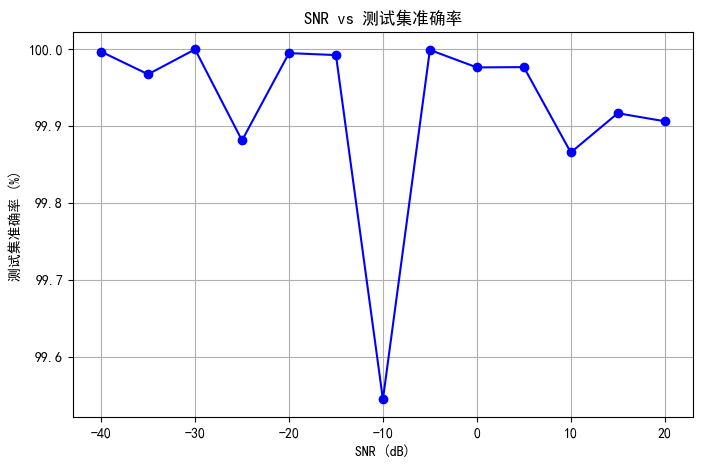

[INFO] SNR vs 测试准确率曲线已保存到 d:\Program\MW-RFF\MW-RFF\training_results\SNR_vs_accuracy.png


In [ ]:
# ResNet 1D 自动 SNR 循环训练脚本
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import h5py
from data_utilities import *

# ================= 参数设置 =================
data_path = "E:/rf_datasets/"  # 数据文件夹
fs = 5e6
fc = 5.9e9
v = 120
apply_doppler = True
apply_awgn = True

# 模型超参数
batch_size = 64
num_epochs = 300
learning_rate = 1e-3
weight_decay = 5e-4
patience = 8
n_splits = 5

# ================= 多普勒和AWGN处理函数 =================
def compute_doppler_shift(v, fc):
    c = 3e8
    v = v/3.6
    return (v / c) * fc

def apply_doppler_shift(signal, fd, fs):
    t = np.arange(signal.shape[-1]) / fs
    doppler_phase = np.exp(1j * 2 * np.pi * fd * t)
    return signal * doppler_phase

def add_awgn(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / (10**(snr_db/10))
    noise_real = np.random.randn(*signal.shape)
    noise_imag = np.random.randn(*signal.shape)
    noise = np.sqrt(noise_power/2) * (noise_real + 1j*noise_imag)
    return signal + noise

# ================= 数据加载 =================
def load_and_preprocess_with_grouping(mat_folder, group_size=288, apply_doppler=False,
                                      target_velocity=30, apply_awgn=False, snr_db=20,
                                      fs=5e6, fc=5.9e9):
    mat_files = glob.glob(os.path.join(mat_folder, '*.mat'))
    print(f"共找到 {len(mat_files)} 个 .mat 文件")
    fd = compute_doppler_shift(target_velocity, fc)
    print(f"目标速度 {target_velocity} km/h，多普勒频移 {fd:.2f} Hz")
    
    X_files, y_files, label_set = [], [], set()
    for file in tqdm(mat_files, desc='读取数据'):
        with h5py.File(file, 'r') as f:
            rfDataset = f['rfDataset']
            dmrs_struct = rfDataset['dmrs'][:]
            dmrs_complex = dmrs_struct['real'] + 1j * dmrs_struct['imag']
            txID_uint16 = rfDataset['txID'][:].flatten()
            tx_id = ''.join(chr(c) for c in txID_uint16 if c != 0)
            
            processed_signals = []
            for i in range(dmrs_complex.shape[0]):
                sig = dmrs_complex[i, :]
                if apply_doppler:
                    sig = apply_doppler_shift(sig, fd, fs)
                if apply_awgn:
                    sig = add_awgn(sig, snr_db)
                iq = np.stack((sig.real, sig.imag), axis=-1)
                processed_signals.append(iq)
            processed_signals = np.array(processed_signals)
            X_files.append(processed_signals)
            y_files.append(tx_id)
            label_set.add(tx_id)
    
    label_list = sorted(list(label_set))
    label_to_idx = {label: i for i, label in enumerate(label_list)}
    X_all_list, y_all_list = [], []
    
    for label in label_list:
        files_idx = [i for i, y in enumerate(y_files) if y == label]
        num_files = len(files_idx)
        if num_files == 0:
            continue
        samples_per_file = group_size // num_files
        if samples_per_file == 0:
            continue
        min_samples = min([X_files[i].shape[0] for i in files_idx])
        max_groups = min_samples // samples_per_file
        if max_groups == 0:
            continue
        for group_i in range(max_groups):
            pieces = []
            for fi in files_idx:
                start = group_i * samples_per_file
                end = start + samples_per_file
                piece = X_files[fi][start:end]
                pieces.append(piece)
            big_block = np.concatenate(pieces, axis=0)
            big_block_t = np.transpose(big_block, (1, 0, 2))
            X_all_list.append(big_block_t)
            y_all_list.append(np.full(group_size, label_to_idx[label], dtype=np.int64))
    
    X_all = np.concatenate(X_all_list, axis=0)
    y_all = np.concatenate(y_all_list, axis=0)
    print(f"[INFO] 样本数: {X_all.shape[0]}, 每样本长度: {X_all.shape[1]}")
    return X_all, y_all, label_to_idx

# ================= 1D ResNet18 =================
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ResNet18_1D(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)
    def _make_layer(self, planes, blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes)
            )
        layers = [BasicBlock1D(self.in_planes, planes, stride, downsample)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.squeeze(-1)
        return self.fc(x)

# ================= 辅助函数 =================
def compute_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += (p.grad.data.norm(2).item()) ** 2
    return total_norm ** 0.5

def moving_average(x, w=5):
    x = np.array(x)
    if len(x) == 0:
        return np.array([])
    if w <= 0:
        w = 1
    if len(x) < w:
        w = len(x)
    return np.convolve(x, np.ones(w), 'valid') / w

def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    acc = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return acc, cm

def plot_training_curves(fold_results, save_folder):
    plt.figure(figsize=(12,5))
    for i, res in enumerate(fold_results):
        plt.plot(moving_average(res['train_loss']), label=f'Fold{i+1} Train Loss')
        plt.plot(moving_average(res['val_loss']), label=f'Fold{i+1} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('训练和验证Loss曲线')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(save_folder, 'loss_curves.png'))
    plt.close()

def plot_grad_norms(avg_grad_norms, save_folder):
    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(avg_grad_norms)+1), avg_grad_norms)
    plt.xlabel('Fold')
    plt.ylabel('平均梯度范数')
    plt.title('各Fold平均梯度范数')
    plt.grid()
    plt.savefig(os.path.join(save_folder, 'avg_grad_norms.png'))
    plt.close()

def plot_confusion_matrix(cm, save_path=None):
    plt.figure(figsize=(8,6))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Reference')
    plt.xlabel('Predicted')
    if save_path:
        plt.savefig(save_path)
    plt.close()

# ================= 主训练函数（可传SNR） =================
# 修改 train_for_snr 函数，返回所有 fold 测试集平均准确率
def train_for_snr(SNR_dB, save_folder, results_file):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] 使用设备: {device}")

    X_all, y_all, label_to_idx = load_and_preprocess_with_grouping(
        data_path, group_size=288, apply_doppler=apply_doppler,
        target_velocity=v, apply_awgn=apply_awgn, snr_db=SNR_dB, fs=fs, fc=fc
    )

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_all, y_all, test_size=0.25, stratify=y_all, random_state=42
    )

    full_dataset = TensorDataset(torch.tensor(X_trainval, dtype=torch.float32),
                                 torch.tensor(y_trainval, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    indices = np.arange(len(full_dataset))
    fold_results = []
    fold_test_accs = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f"\n====== Fold {fold+1}/{n_splits} ======")
        train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=batch_size, shuffle=False)

        model = ResNet18_1D(num_classes=len(label_to_idx)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        best_val_acc = 0.0
        patience_counter = 0
        best_model_wts = None
        train_losses, val_losses, grad_norms = [], [], []

        for epoch in range(num_epochs):
            model.train()
            running_loss, correct_train, total_train = 0.0, 0, 0
            batch_grad_norms = []

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                grad_norm = compute_grad_norm(model)
                batch_grad_norms.append(grad_norm)
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct_train / total_train
            avg_grad_norm = np.mean(batch_grad_norms)
            train_losses.append(train_loss)
            grad_norms.append(avg_grad_norm)

            # 验证集 loss & acc
            model.eval()
            running_val_loss, correct_val, total_val = 0.0, 0, 0
            all_val_labels, all_val_preds = [], []
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    loss_val = criterion(val_outputs, val_labels)
                    running_val_loss += loss_val.item()
                    _, val_predicted = torch.max(val_outputs, 1)
                    total_val += val_labels.size(0)
                    correct_val += (val_predicted == val_labels).sum().item()
                    all_val_labels.extend(val_labels.cpu().numpy())
                    all_val_preds.extend(val_predicted.cpu().numpy())
            val_loss = running_val_loss / len(val_loader)
            val_acc = 100 * correct_val / total_val
            val_losses.append(val_loss)
            val_cm = confusion_matrix(all_val_labels, all_val_preds, labels=range(len(label_to_idx)))

            # 打印 & 写入结果文件
            log_msg = (f"Fold {fold+1}, Epoch {epoch+1}: "
                       f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
                       f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%, Grad Norm={avg_grad_norm:.4f}")
            print(log_msg)
            with open(results_file, "a") as f:
                f.write(log_msg + "\n")

            # 早停
            if val_acc > best_val_acc + 0.01:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_wts = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"早停，连续 {patience} 个 epoch 验证集未提升")
                    with open(results_file, "a") as f:
                        f.write(f"早停，连续 {patience} 个 epoch 验证集未提升\n")
                    break
            scheduler.step()

        # 保存最佳模型 & 测试集评估
        model.load_state_dict(best_model_wts)
        test_acc, all_test_cm = evaluate_model(model, test_loader, device, len(label_to_idx))
        fold_test_accs.append(test_acc)

        # 保存训练/验证loss和梯度范数
        fold_results.append({
            'train_loss': train_losses,
            'val_loss': val_losses,
            'grad_norms': grad_norms,
            'val_cm': val_cm,
            'test_cm': all_test_cm
        })

        # 保存混淆矩阵图片
        plot_confusion_matrix(val_cm, save_path=os.path.join(save_folder, f"confusion_matrix_val_fold{fold+1}.png"))
        plot_confusion_matrix(all_test_cm, save_path=os.path.join(save_folder, f"confusion_matrix_test_fold{fold+1}.png"))
        torch.save(best_model_wts, os.path.join(save_folder, f"best_model_fold{fold+1}.pth"))

        print(f"Fold {fold+1} Test Acc={test_acc:.2f}%\n")
        with open(results_file, "a") as f:
            f.write(f"Fold {fold+1} Test Acc={test_acc:.2f}%\n")

    # 保存训练曲线 & 梯度范数
    plot_training_curves(fold_results, save_folder)
    plot_grad_norms([np.mean(f['grad_norms']) for f in fold_results], save_folder)

    return np.mean(fold_test_accs)

# ================= SNR 循环训练 + 绘制 SNR 曲线 =================
if __name__ == "__main__":
    snr_list = list(range(20, -45, -5))
    snr_accs = []

    for snr_db in snr_list:
        print(f"\n\n================== 当前实验 SNR={snr_db} dB ==================\n")
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        script_name = "LTE-V_cross_fluently"
        label_to_idx = 20
        folder_name = f"{timestamp}_{script_name}_SNR{snr_db}dB_fd{int(compute_doppler_shift(v, fc))}_classes_{label_to_idx}_ResNet"
        save_folder = os.path.join(os.getcwd(), "training_results", folder_name)
        os.makedirs(save_folder, exist_ok=True)
        results_file = os.path.join(save_folder, "results.txt")
        with open(results_file, "a") as f:
            f.write(f"\n================ SNR={snr_db} dB =================\n")
        test_acc = train_for_snr(snr_db, save_folder, results_file)
        snr_accs.append(test_acc)
        print(f"SNR {snr_db:>3} dB → results in: {save_folder}")
        
    # 绘制 SNR vs 测试准确率曲线
    plt.figure(figsize=(8,5))
    plt.plot(snr_list, snr_accs, marker='o', linestyle='-', color='b')
    plt.xlabel("SNR (dB)")
    plt.ylabel("测试集准确率 (%)")
    plt.title("SNR vs 测试集准确率")
    plt.grid(True)
    snr_curve_path = os.path.join(os.getcwd(), "training_results", f"SNR_vs_accuracy.png")
    plt.savefig(snr_curve_path)
    plt.show()
    print(f"[INFO] SNR vs 测试准确率曲线已保存到 {snr_curve_path}")



In [ ]:
# ResNet 1D 自动 SNR 循环训练脚本（按 block 整体划分训练/测试）
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import h5py
from data_utilities import *

# ================= 参数设置 =================
data_path = "E:/rf_datasets/"  # 数据文件夹
fs = 5e6
fc = 5.9e9
v = 120
apply_doppler = True
apply_awgn = True

# 模型超参数
batch_size = 64
num_epochs = 300
learning_rate = 1e-3
weight_decay = 5e-4
patience = 8
n_splits = 5

# ================= 多普勒和AWGN处理函数 =================
def compute_doppler_shift(v, fc):
    c = 3e8
    v = v/3.6
    return (v / c) * fc

def apply_doppler_shift(signal, fd, fs):
    t = np.arange(signal.shape[-1]) / fs
    doppler_phase = np.exp(1j * 2 * np.pi * fd * t)
    return signal * doppler_phase

def add_awgn(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / (10**(snr_db/10))
    noise_real = np.random.randn(*signal.shape)
    noise_imag = np.random.randn(*signal.shape)
    noise = np.sqrt(noise_power/2) * (noise_real + 1j*noise_imag)
    return signal + noise

# ================= 数据加载（按 block 保存） =================
def load_and_preprocess_with_grouping(mat_folder, group_size=288, apply_doppler=False,
                                      target_velocity=30, apply_awgn=False, snr_db=20,
                                      fs=5e6, fc=5.9e9):
    """
    改动说明：
      - 每个 big_block 保持为整体 (group_size, sample_len, 2)
      - 返回 X_blocks: shape (num_blocks, group_size, sample_len, 2)
      - 返回 y_blocks: shape (num_blocks,) 对应每个 block 的 label（单个整数）
    """
    mat_files = glob.glob(os.path.join(mat_folder, '*.mat'))
    print(f"共找到 {len(mat_files)} 个 .mat 文件")
    fd = compute_doppler_shift(target_velocity, fc)
    print(f"目标速度 {target_velocity} km/h，多普勒频移 {fd:.2f} Hz")
    
    X_files, y_files, label_set = [], [], set()
    for file in tqdm(mat_files, desc='读取数据'):
        with h5py.File(file, 'r') as f:
            rfDataset = f['rfDataset']
            dmrs_struct = rfDataset['dmrs'][:]
            dmrs_complex = dmrs_struct['real'] + 1j * dmrs_struct['imag']
            txID_uint16 = rfDataset['txID'][:].flatten()
            tx_id = ''.join(chr(c) for c in txID_uint16 if c != 0)
            
            processed_signals = []
            for i in range(dmrs_complex.shape[0]):
                sig = dmrs_complex[i, :]
                if apply_doppler:
                    sig = apply_doppler_shift(sig, fd, fs)
                if apply_awgn:
                    sig = add_awgn(sig, snr_db)
                iq = np.stack((sig.real, sig.imag), axis=-1)  # (sample_len, 2)
                processed_signals.append(iq)
            processed_signals = np.array(processed_signals)  # (num_samples_file, sample_len, 2)
            X_files.append(processed_signals)
            y_files.append(tx_id)
            label_set.add(tx_id)
    
    label_list = sorted(list(label_set))
    label_to_idx = {label: i for i, label in enumerate(label_list)}
    X_blocks_list = []   # 每个元素是一个 big_block (group_size, sample_len, 2)
    y_blocks_list = []   # 每个元素是单个 label idx
    
    for label in label_list:
        files_idx = [i for i, y in enumerate(y_files) if y == label]
        num_files = len(files_idx)
        if num_files == 0:
            continue
        samples_per_file = group_size // num_files
        if samples_per_file == 0:
            # 如果太多文件导致每文件取样为0，跳过该类别
            print(f"[WARN] 类别 {label} 文件数量过多，导致每文件样本数为0，跳过该类别")
            continue
        min_samples = min([X_files[i].shape[0] for i in files_idx])
        max_groups = min_samples // samples_per_file
        if max_groups == 0:
            print(f"[WARN] 类别 {label} 样本不足，跳过")
            continue
        for group_i in range(max_groups):
            pieces = []
            for fi in files_idx:
                start = group_i * samples_per_file
                end = start + samples_per_file
                piece = X_files[fi][start:end]  # (samples_per_file, sample_len, 2)
                pieces.append(piece)
            # big_block shape: (num_files * samples_per_file (=group_size), sample_len, 2)
            big_block = np.concatenate(pieces, axis=0)  # (group_size, sample_len, 2)
            # 保存整个 block（不拆开）
            X_blocks_list.append(big_block)
            y_blocks_list.append(label_to_idx[label])
    
    # 转为数组
    if len(X_blocks_list) == 0:
        raise RuntimeError("没有生成任何 block，请检查数据/group_size 设置")
    X_blocks = np.stack(X_blocks_list, axis=0)  # (num_blocks, group_size, sample_len, 2)
    y_blocks = np.array(y_blocks_list, dtype=np.int64)  # (num_blocks,)
    
    print(f"[INFO] 生成 block 数: {X_blocks.shape[0]}, 每 block 包含样本数: {X_blocks.shape[1]}, 每样本长度: {X_blocks.shape[2]}")
    return X_blocks, y_blocks, label_to_idx

# ================= 1D ResNet18 （保持不变） =================
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ResNet18_1D(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)
    def _make_layer(self, planes, blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes)
            )
        layers = [BasicBlock1D(self.in_planes, planes, stride, downsample)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, sample_len, 2) -> (B, 2, sample_len)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.squeeze(-1)
        return self.fc(x)

# ================= 辅助函数（保持不变） =================
def compute_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += (p.grad.data.norm(2).item()) ** 2
    return total_norm ** 0.5

def moving_average(x, w=5):
    x = np.array(x)
    if len(x) == 0:
        return np.array([])
    if w <= 0:
        w = 1
    if len(x) < w:
        w = len(x)
    return np.convolve(x, np.ones(w), 'valid') / w

def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    acc = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return acc, cm

def plot_training_curves(fold_results, save_folder):
    plt.figure(figsize=(12,5))
    for i, res in enumerate(fold_results):
        plt.plot(moving_average(res['train_loss']), label=f'Fold{i+1} Train Loss')
        plt.plot(moving_average(res['val_loss']), label=f'Fold{i+1} Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('训练和验证Loss曲线')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(save_folder, 'loss_curves.png'))
    plt.close()

def plot_grad_norms(avg_grad_norms, save_folder):
    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(avg_grad_norms)+1), avg_grad_norms)
    plt.xlabel('Fold')
    plt.ylabel('平均梯度范数')
    plt.title('各Fold平均梯度范数')
    plt.grid()
    plt.savefig(os.path.join(save_folder, 'avg_grad_norms.png'))
    plt.close()

def plot_confusion_matrix(cm, save_path=None):
    plt.figure(figsize=(8,6))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Reference')
    plt.xlabel('Predicted')
    if save_path:
        plt.savefig(save_path)
    plt.close()

# ================= 主训练函数（按 block 划分） =================
def train_for_snr(SNR_dB, save_folder, results_file, group_size=288):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] 使用设备: {device}")

    # 1) 加载 block（每个 block 是整体）
    X_blocks, y_blocks, label_to_idx = load_and_preprocess_with_grouping(
        data_path, group_size=group_size, apply_doppler=apply_doppler,
        target_velocity=v, apply_awgn=apply_awgn, snr_db=SNR_dB, fs=fs, fc=fc
    )
    num_blocks = X_blocks.shape[0]
    print(f"[INFO] 总 block 数: {num_blocks}")

    # 2) 按 block 做 train/test 划分（保证同一 block 不会被拆分）
    block_idx = np.arange(num_blocks)
    train_block_idx, test_block_idx, y_train_blocks, y_test_blocks = train_test_split(
        block_idx, y_blocks, test_size=0.25, stratify=y_blocks, random_state=42
    )

    # 3) 将训练 block 展开为样本（每个 block 包含 group_size 条样本）
    #    同时保持测试 block 也展开用于最终评估
    X_train_blocks = X_blocks[train_block_idx]  # (num_train_blocks, group_size, sample_len, 2)
    y_train_blocks = y_blocks[train_block_idx]  # (num_train_blocks,)

    X_test_blocks = X_blocks[test_block_idx]
    y_test_blocks = y_blocks[test_block_idx]

    # 展开：把 train blocks -> (num_train_blocks * group_size, sample_len, 2)
    X_train = X_train_blocks.reshape(-1, X_train_blocks.shape[2], X_train_blocks.shape[3])
    y_train = np.repeat(y_train_blocks, X_train_blocks.shape[1])

    X_test = X_test_blocks.reshape(-1, X_test_blocks.shape[2], X_test_blocks.shape[3])
    y_test = np.repeat(y_test_blocks, X_test_blocks.shape[1])

    print(f"[INFO] 展开后训练样本数: {X_train.shape[0]}, 测试样本数: {X_test.shape[0]}")

    # 4) 构造 Dataset / DataLoader
    full_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                 torch.tensor(y_train, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 5) KFold 在训练样本上做交叉验证（注意：KFold 是对样本级的索引划分，这里没有破坏 block 完整性）
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    indices = np.arange(len(full_dataset))
    fold_results = []
    fold_test_accs = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f"\n====== Fold {fold+1}/{n_splits} ======")
        train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=batch_size, shuffle=False)

        model = ResNet18_1D(num_classes=len(label_to_idx)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

        best_val_acc = 0.0
        patience_counter = 0
        best_model_wts = None
        train_losses, val_losses, grad_norms = [], [], []

        for epoch in range(num_epochs):
            model.train()
            running_loss, correct_train, total_train = 0.0, 0, 0
            batch_grad_norms = []

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                grad_norm = compute_grad_norm(model)
                batch_grad_norms.append(grad_norm)
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct_train / total_train
            avg_grad_norm = np.mean(batch_grad_norms)
            train_losses.append(train_loss)
            grad_norms.append(avg_grad_norm)

            # 验证集 loss & acc
            model.eval()
            running_val_loss, correct_val, total_val = 0.0, 0, 0
            all_val_labels, all_val_preds = [], []
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    loss_val = criterion(val_outputs, val_labels)
                    running_val_loss += loss_val.item()
                    _, val_predicted = torch.max(val_outputs, 1)
                    total_val += val_labels.size(0)
                    correct_val += (val_predicted == val_labels).sum().item()
                    all_val_labels.extend(val_labels.cpu().numpy())
                    all_val_preds.extend(val_predicted.cpu().numpy())
            val_loss = running_val_loss / len(val_loader)
            val_acc = 100 * correct_val / total_val
            val_losses.append(val_loss)
            val_cm = confusion_matrix(all_val_labels, all_val_preds, labels=range(len(label_to_idx)))

            # 打印 & 写入结果文件
            log_msg = (f"Fold {fold+1}, Epoch {epoch+1}: "
                       f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
                       f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%, Grad Norm={avg_grad_norm:.4f}")
            print(log_msg)
            with open(results_file, "a") as f:
                f.write(log_msg + "\n")

            # 早停
            if val_acc > best_val_acc + 0.01:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_wts = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"早停，连续 {patience} 个 epoch 验证集未提升")
                    with open(results_file, "a") as f:
                        f.write(f"早停，连续 {patience} 个 epoch 验证集未提升\n")
                    break
            scheduler.step()

        # 保存最佳模型 & 测试集评估
        model.load_state_dict(best_model_wts)
        test_acc, all_test_cm = evaluate_model(model, test_loader, device, len(label_to_idx))
        fold_test_accs.append(test_acc)

        # 保存训练/验证loss和梯度范数
        fold_results.append({
            'train_loss': train_losses,
            'val_loss': val_losses,
            'grad_norms': grad_norms,
            'val_cm': val_cm,
            'test_cm': all_test_cm
        })

        # 保存混淆矩阵图片
        plot_confusion_matrix(val_cm, save_path=os.path.join(save_folder, f"confusion_matrix_val_fold{fold+1}.png"))
        plot_confusion_matrix(all_test_cm, save_path=os.path.join(save_folder, f"confusion_matrix_test_fold{fold+1}.png"))
        torch.save(best_model_wts, os.path.join(save_folder, f"best_model_fold{fold+1}.pth"))

        print(f"Fold {fold+1} Test Acc={test_acc:.2f}%\n")
        with open(results_file, "a") as f:
            f.write(f"Fold {fold+1} Test Acc={test_acc:.2f}%\n")

    # 保存训练曲线 & 梯度范数
    plot_training_curves(fold_results, save_folder)
    plot_grad_norms([np.mean(f['grad_norms']) for f in fold_results], save_folder)

    return np.mean(fold_test_accs)

# ================= SNR 循环训练 + 绘制 SNR 曲线 =================
if __name__ == "__main__":
    snr_list = list(range(-30, -45, -5))
    snr_accs = []

    for snr_db in snr_list:
        print(f"\n\n================== 当前实验 SNR={snr_db} dB ==================\n")
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        script_name = "LTE-V_cross_fluently"
        label_to_idx = 20
        folder_name = f"{timestamp}_{script_name}_SNR{snr_db}dB_fd{int(compute_doppler_shift(v, fc))}_classes_{label_to_idx}_ResNet"
        save_folder = os.path.join(os.getcwd(), "training_results", folder_name)
        os.makedirs(save_folder, exist_ok=True)
        results_file = os.path.join(save_folder, "results.txt")
        with open(results_file, "a") as f:
            f.write(f"\n================ SNR={snr_db} dB =================\n")
        test_acc = train_for_snr(snr_db, save_folder, results_file, group_size=288)
        snr_accs.append(test_acc)
        print(f"SNR {snr_db:>3} dB → results in: {save_folder}")
        
    # 绘制 SNR vs 测试准确率曲线
    plt.figure(figsize=(8,5))
    plt.plot(snr_list, snr_accs, marker='o', linestyle='-', color='b')
    plt.xlabel("SNR (dB)")
    plt.ylabel("测试集准确率 (%)")
    plt.title("SNR vs 测试集准确率")
    plt.grid(True)
    snr_curve_path = os.path.join(os.getcwd(), "training_results", f"SNR_vs_accuracy.png")
    plt.savefig(snr_curve_path)
    plt.show()
    print(f"[INFO] SNR vs 测试准确率曲线已保存到 {snr_curve_path}")




================== 当前实验 SNR=20 dB ==================

[INFO] 使用设备: cuda
共找到 72 个 .mat 文件
目标速度 120 km/h，多普勒频移 655.56 Hz


读取数据: 100%|██████████| 72/72 [00:08<00:00,  8.27it/s]


[INFO] 生成 block 数: 747, 每 block 包含样本数: 288, 每样本长度: 288
[INFO] 总 block 数: 747
[INFO] 展开后训练样本数: 161280, 测试样本数: 53856

====== Fold 1/5 ======
Fold 1, Epoch 1: Train Loss=2.1208, Train Acc=18.02%, Val Loss=2.0449, Val Acc=20.82%, Grad Norm=1.9769
Fold 1, Epoch 2: Train Loss=1.8543, Train Acc=31.50%, Val Loss=2.6691, Val Acc=19.56%, Grad Norm=1.3218
Fold 1, Epoch 3: Train Loss=1.6909, Train Acc=38.41%, Val Loss=2.4693, Val Acc=22.14%, Grad Norm=1.7698
Fold 1, Epoch 4: Train Loss=1.6197, Train Acc=41.23%, Val Loss=2.1996, Val Acc=28.10%, Grad Norm=2.1092
Fold 1, Epoch 5: Train Loss=1.5769, Train Acc=42.97%, Val Loss=1.9762, Val Acc=31.45%, Grad Norm=2.3332
Fold 1, Epoch 6: Train Loss=1.5457, Train Acc=44.34%, Val Loss=2.7878, Val Acc=26.52%, Grad Norm=2.5115
Fold 1, Epoch 7: Train Loss=1.5255, Train Acc=44.94%, Val Loss=2.5658, Val Acc=27.27%, Grad Norm=2.6115
Fold 1, Epoch 8: Train Loss=1.5060, Train Acc=45.87%, Val Loss=1.8295, Val Acc=32.42%, Grad Norm=2.6753
Fold 1, Epoch 9: Train Loss=1

KeyboardInterrupt: 

In [ ]:
# ================= 网格搜索训练脚本（ResNet 1D，按 block 划分） =================
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import h5py
from itertools import product
import random

# ================= 参数设置 =================
data_path = "E:/rf_datasets/"
fs = 5e6
fc = 5.9e9
v = 120
apply_doppler = True
apply_awgn = True
patience = 8
group_size = 288
num_epochs = 200

# ================= 多普勒和AWGN处理 =================
def compute_doppler_shift(v, fc):
    c = 3e8
    v = v / 3.6
    return (v / c) * fc

def apply_doppler_shift(signal, fd, fs):
    t = np.arange(signal.shape[-1]) / fs
    doppler_phase = np.exp(1j * 2 * np.pi * fd * t)
    return signal * doppler_phase

def add_awgn(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / (10**(snr_db/10))
    noise_real = np.random.randn(*signal.shape)
    noise_imag = np.random.randn(*signal.shape)
    noise = np.sqrt(noise_power/2) * (noise_real + 1j*noise_imag)
    return signal + noise

# ================= 数据加载（按 block） =================
def load_and_preprocess_with_grouping(mat_folder, group_size=288, apply_doppler=False,
                                      target_velocity=30, apply_awgn=False, snr_db=20,
                                      fs=5e6, fc=5.9e9):
    mat_files = glob.glob(os.path.join(mat_folder, '*.mat'))
    print(f"共找到 {len(mat_files)} 个 .mat 文件")
    fd = compute_doppler_shift(target_velocity, fc)
    
    X_files, y_files, label_set = [], [], set()
    for file in tqdm(mat_files):
        with h5py.File(file, 'r') as f:
            rfDataset = f['rfDataset']
            dmrs_struct = rfDataset['dmrs'][:]
            dmrs_complex = dmrs_struct['real'] + 1j*dmrs_struct['imag']
            txID_uint16 = rfDataset['txID'][:].flatten()
            tx_id = ''.join(chr(c) for c in txID_uint16 if c != 0)
            
            processed_signals = []
            for i in range(dmrs_complex.shape[0]):
                sig = dmrs_complex[i, :]
                if apply_doppler:
                    sig = apply_doppler_shift(sig, fd, fs)
                if apply_awgn:
                    sig = add_awgn(sig, snr_db)
                iq = np.stack((sig.real, sig.imag), axis=-1)
                processed_signals.append(iq)
            X_files.append(np.array(processed_signals))
            y_files.append(tx_id)
            label_set.add(tx_id)
    
    label_list = sorted(list(label_set))
    label_to_idx = {label: i for i, label in enumerate(label_list)}
    X_blocks_list, y_blocks_list = [], []
    
    for label in label_list:
        files_idx = [i for i, y in enumerate(y_files) if y == label]
        num_files = len(files_idx)
        if num_files == 0: continue
        samples_per_file = group_size // num_files
        min_samples = min([X_files[i].shape[0] for i in files_idx])
        max_groups = min_samples // samples_per_file
        if max_groups == 0: continue
        for g in range(max_groups):
            pieces = [X_files[fi][g*samples_per_file:(g+1)*samples_per_file] for fi in files_idx]
            big_block = np.concatenate(pieces, axis=0)
            X_blocks_list.append(big_block)
            y_blocks_list.append(label_to_idx[label])
    
    X_blocks = np.stack(X_blocks_list)
    y_blocks = np.array(y_blocks_list, dtype=np.int64)
    return X_blocks, y_blocks, label_to_idx

# ================= 1D BasicBlock =================
class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(planes, planes, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

# ================= ResNet18_1D 可调超参 =================
class ResNet18_1D_Mod(nn.Module):
    def __init__(self, num_classes, in_planes=64, dropout_p=0.0):
        super().__init__()
        self.in_planes = in_planes
        self.conv1 = nn.Conv1d(2, in_planes, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(3, stride=2, padding=1)
        self.layer1 = self._make_layer(in_planes, 2, stride=1)
        self.layer2 = self._make_layer(in_planes*2, 2, stride=2)
        self.layer3 = self._make_layer(in_planes*4, 2, stride=2)
        self.layer4 = self._make_layer(in_planes*8, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(in_planes*8, num_classes)
    def _make_layer(self, planes, blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_planes, planes, 1, stride=stride, bias=False),
                nn.BatchNorm1d(planes)
            )
        layers = [BasicBlock1D(self.in_planes, planes, stride, downsample)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

# ================= 网格搜索训练函数（带日志保存） =================
def train_grid_search(X_blocks, y_blocks, label_to_idx, snr_db, params, save_folder):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 日志文件
    log_file = os.path.join(save_folder, f"log_SNR{snr_db}_in{params['in_planes']}_drop{params['dropout_p']}.txt")
    with open(log_file, "w") as f_log:
        f_log.write(f"Training log for params: {params}\n")
    
    # 按 block 划分 train/test
    num_blocks = X_blocks.shape[0]
    block_idx = np.arange(num_blocks)
    train_block_idx, test_block_idx, y_train_blocks, y_test_blocks = train_test_split(
        block_idx, y_blocks, test_size=0.25, stratify=y_blocks, random_state=42
    )
    
    X_train = X_blocks[train_block_idx].reshape(-1, X_blocks.shape[2], X_blocks.shape[3])
    y_train = np.repeat(y_blocks[train_block_idx], X_blocks.shape[1])
    X_test = X_blocks[test_block_idx].reshape(-1, X_blocks.shape[2], X_blocks.shape[3])
    y_test = np.repeat(y_blocks[test_block_idx], X_blocks.shape[1])
    
    train_dataset = TensorDataset(torch.tensor(X_train,dtype=torch.float32),
                                  torch.tensor(y_train,dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test,dtype=torch.float32),
                                 torch.tensor(y_test,dtype=torch.long))
    
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)
    
    model = ResNet18_1D_Mod(num_classes=len(label_to_idx),
                            in_planes=params['in_planes'],
                            dropout_p=params['dropout_p']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    best_val_acc = 0.0
    patience_counter = 0
    best_model_wts = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, pred = torch.max(outputs,1)
            total += labels.size(0)
            correct += (pred==labels).sum().item()
        
        train_acc = 100*correct/total
        
        # 验证集
        model.eval()
        correct_val, total_val = 0,0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, pred = torch.max(outputs,1)
                total_val += labels.size(0)
                correct_val += (pred==labels).sum().item()
        val_acc = 100*correct_val/total_val
        
        # 打印并保存到日志
        log_line = f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
        print(log_line)
        with open(log_file, "a") as f_log:
            f_log.write(log_line + "\n")
        
        if val_acc > best_val_acc + 0.01:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                with open(log_file, "a") as f_log:
                    f_log.write(f"Early stopping at epoch {epoch+1}\n")
                break
        scheduler.step()
    
    model.load_state_dict(best_model_wts)
    
    # 测试集最终评估
    model.eval()
    correct_test, total_test = 0,0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs,1)
            correct_test += (pred==labels).sum().item()
            total_test += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())
    test_acc = 100*correct_test/total_test
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(label_to_idx)))
    
    # 保存混淆矩阵
    cm_path = os.path.join(save_folder,f"confusion_matrix_SNR{snr_db}_in{params['in_planes']}_drop{params['dropout_p']}.png")
    plot_confusion_matrix(cm, save_path=cm_path)
    
    # 保存最终测试准确率到日志
    with open(log_file, "a") as f_log:
        f_log.write(f"Final Test Acc: {test_acc:.2f}%\n")
    
    return test_acc

# ================= 绘图函数 =================
def plot_confusion_matrix(cm, save_path=None):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Reference')
    plt.xlabel('Predicted')
    if save_path:
        plt.savefig(save_path)
    plt.close()


# ================= 主函数：随机网格搜索（带文件夹保存） =================
if __name__ == "__main__":
    snr_db = 20  # 固定SNR，可改
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    script_name = "LTE-V_cross_fluently_ran"
    label_to_idx = 9
    folder_name = f"{timestamp}_{script_name}_SNR{snr_db}dB_fd{int(compute_doppler_shift(v, fc))}_classes_{label_to_idx}_ResNet"
    base_save_folder = os.path.join(os.getcwd(), "search_results", folder_name)
    os.makedirs(base_save_folder, exist_ok=True)
    
    # 加载数据
    X_blocks, y_blocks, label_to_idx = load_and_preprocess_with_grouping(
        data_path, group_size=group_size,
        apply_doppler=apply_doppler,
        target_velocity=v,
        apply_awgn=apply_awgn,
        snr_db=snr_db, fs=fs, fc=fc
    )
    
    # 网格超参数
    param_grid = {
        'in_planes': [16, 32, 64],
        'dropout_p': [0.3, 0.5, 0.7],
        'weight_decay': [1e-3, 5e-3],
        'learning_rate': [5e-4, 1e-4],
        'batch_size': [64, 128, 256]
    }

    # 生成所有组合
    all_combinations = list(product(*param_grid.values()))
    random.shuffle(all_combinations)  # 打乱顺序
    X_experiments = 10  # 随机抽取的组合数
    selected_combinations = all_combinations[:X_experiments]
    
    # 汇总 CSV 文件路径
    summary_csv = os.path.join(base_save_folder, f"summary_SNR{snr_db}.csv")
    with open(summary_csv, "w") as f:
        f.write("in_planes,dropout_p,weight_decay,learning_rate,batch_size,test_acc\n")
    
    for i, values in enumerate(selected_combinations):
        params = dict(zip(param_grid.keys(), values))
        
        # 为每组参数创建子文件夹
        param_folder = os.path.join(base_save_folder, f"exp_{i}_in{params['in_planes']}_drop{params['dropout_p']}")
        os.makedirs(param_folder, exist_ok=True)
        
        print(f"\n================ Training Experiment {i} with params: {params} =================")
        test_acc = train_grid_search(X_blocks, y_blocks, label_to_idx, snr_db, params, param_folder)
        print(f"Experiment {i} Test Acc={test_acc:.2f}%")
        
        # 保存到汇总 CSV
        with open(summary_csv, "a") as f:
            f.write(f"{params['in_planes']},{params['dropout_p']},{params['weight_decay']},{params['learning_rate']},{params['batch_size']},{test_acc:.2f}\n")


共找到 72 个 .mat 文件


100%|██████████| 72/72 [00:08<00:00,  8.26it/s]



================ Training Experiment 0 with params: {'in_planes': 64, 'dropout_p': 0.3, 'weight_decay': 0.005, 'learning_rate': 0.0001, 'batch_size': 128} =================
Epoch 1/200 - Train Acc: 21.84% | Val Acc: 29.46%
Epoch 2/200 - Train Acc: 36.43% | Val Acc: 33.96%
Epoch 3/200 - Train Acc: 41.91% | Val Acc: 38.91%
Epoch 4/200 - Train Acc: 45.01% | Val Acc: 42.67%
Epoch 5/200 - Train Acc: 47.11% | Val Acc: 38.40%
Epoch 6/200 - Train Acc: 48.73% | Val Acc: 40.29%
Epoch 7/200 - Train Acc: 49.97% | Val Acc: 41.51%
Epoch 8/200 - Train Acc: 51.07% | Val Acc: 42.48%
Epoch 9/200 - Train Acc: 51.77% | Val Acc: 44.70%
Epoch 10/200 - Train Acc: 52.55% | Val Acc: 38.80%
Epoch 11/200 - Train Acc: 55.85% | Val Acc: 48.74%
Epoch 12/200 - Train Acc: 56.98% | Val Acc: 45.92%
Epoch 13/200 - Train Acc: 58.04% | Val Acc: 42.28%
Epoch 14/200 - Train Acc: 58.95% | Val Acc: 41.29%
Epoch 15/200 - Train Acc: 59.82% | Val Acc: 48.14%
Epoch 16/200 - Train Acc: 60.83% | Val Acc: 47.30%
Epoch 17/200 - Trai